__[Open and try this file online (Colab)](https://colab.research.google.com/github/djekra/wiktionary_wortschatz/blob/master/1_wiktionary_parsen/x34_d01_tag_und_member.ipynb)__

# tag und member
* speichert in data_01
* 17 min
* lex_test level 1
-----


* erstellt die Felder tag und member 
* integriert lexeme_manuell und named_entities
* Löschen laut löschliste
* behandelt Partizipien

* erstellt dort wiktionary_lemma und wiktionary_nolemma
* wiktionary ist danach überflüssig


### Doku
* __Abkürzungen__ stehen immer in wiktionary_merkmal (merkmal abk) und manchmal auch als eigenständiges Lemma in wiktionary_lemma.
  In wiktionary_lemma werden Abkürzungen durch das member 'Abkürzung' gekennzeichnet. 
  Das gibt die Information, dass es sich lohnt, in wiktionary_merkmal nachzuschlagen, um die Bedeutung einer Abkürzung zu erfahren.

* __Partizipien__ stehen in wiktionary_merkmal. Ihr lemma ist das Verb im Infinitiv (das ist oft falsch eingetragen). Ihr tag lautet 'VVPP ADJA' für Ptz2 bzw. 'VVFIN ADJA' für Ptz1, ihr member ist Ptz1 bzw. Ptz2.
  Zusätzlich sind alle Partizipien aber auch als Adjektiv als eigenständiges lemma registriert. Dort weist data_id auf das Verb zurück.
  
### TODO 
* named_entities: section_id2 von existierenden Einträgen übertragen

  
### TODO Ganz am Ende, wenn alles komplett fertig ist:
* TODO_verwaiste_Wörter: Wichtige Wörter nachverfolgen. 
* TODO_TAGS_IN_MERKMALE: Sind diese Lexeme im Endergebnis enthalten? Gehören die nicht in wiktionary_nolemma??
* TODO_MEMBER_ÜBERPRÜFEN: Sind diese Informationen im Endergebnis enthalten?
* TODO_Widersprüchliche_Angaben

## Import

In [2]:
# blab init
try:
    import blab
except ImportError as e:
    !pip install blab
    import blab    
startup_notebook = blab.blab_startup()
%run $startup_notebook 

blab init
environment['in_colab']     = False
environment['dropbox_path'] = /home/me/Data_Linux/Dropbox
environment['lib_path']     = /home/me/Data_Linux/Dropbox/31_Projekte/01_Python/libs
Start Time: 23:03:19


In [3]:
# pandas
if environment['in_colab']:
    !pip install --upgrade pandas
import pandas as pd

In [4]:
# alle anderen
try:
    import pandasklar as pak, bpyth as bpy, bj_nlp

except ImportError as e:
    !pip install pandasklar bj_nlp
    import pandasklar as pak, bpyth as bpy, bj_nlp
    
grid       = pak.grid
check_mask = pak.check_mask      

## Einstellungen

In [5]:
# Einstellungen

# Was debuggen?
suche_debug = ['gefriergetrocknet','gefriertrocknen','missraten']  

gründlich          = True    # einige Arbeitsschritte können weggelassen werden, wenn gründlich = False
speicher_freigeben = False    # sollen alte Ergebnisse gelöscht werden
version            = '_all'
#version           = '_100K'




# verbose
pak.Config.set('VERBOSE', True)

# Load
verzeichnis_load                      = 'data_00'
wiktionary_filename                   = verzeichnis_load + '/wiktionary'              + version + '.pickle'  
wiktionary_trash_filename             = verzeichnis_load + '/wiktionary_trash'        + version + '.pickle'
wiktionary_merkmal_filename           = verzeichnis_load + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename      = verzeichnis_load + '/wiktionary_merkmal_text' + version + '.pickle'  

# Steuertabellen, externe und manuelle Daten
löschliste_filename                   = 'Steuertabellen/löschliste.xlsx'     
lexeme_manuell_filename               = 'Steuertabellen/lexeme_manuell.xlsx'       # manuell eingepflegte Lexeme 
named_entities_filename               = 'Steuertabellen/named_entities_02.xlsx'    # Vornamen, Nachnamen, Orte
lex_test_filename                     = 'Steuertabellen/lex_test.xlsx'     

# Save
verzeichnis_save                      = 'data_01'
wiktionary_lemma_filename_save        = verzeichnis_save + '/wiktionary_lemma'        + version + '.pickle'  
wiktionary_nolemma_filename_save      = verzeichnis_save + '/wiktionary_nolemma'      + version + '.pickle'  
wiktionary_merkmal_filename_save      = verzeichnis_save + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename_save = verzeichnis_save + '/wiktionary_merkmal_text' + version + '.pickle'  

#
# Einige hardcodierte Tags finden sich unter wiktionary Einzelkorrekturen
# !!!

VERBOSE = True
--> setting verbose=True as default for all pandasklar functions



## Vorbereiten

In [6]:
# Verzeichnisse erzeugen
os.makedirs(verzeichnis_load, exist_ok=True) 
os.makedirs(verzeichnis_save, exist_ok=True) 

In [7]:
# Steuertabellen und Python-Files von Github herunterladen
import os
if not os.path.exists('Steuertabellen'):
   !git clone https://github.com/djekra/wiktionary_wortschatz.git
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/Steuertabellen Steuertabellen
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/*.py .
#   !rm -r wiktionary_wortschatz

In [8]:
# Lade Ergebnisse der vorherigen Verarbeitungsstufe von Google Drive, falls nicht lokal vorhanden
# Dieses Verzeichnis wurde in der vorherigen Verarbeitungsstufe angelegt 
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av /content/drive/MyDrive/{verzeichnis_load} .

In [9]:
# Weitere Imports
from x32_Funktionen                    import *
from Steuertabellen.s01_Steuertabellen import *
from collections                       import defaultdict

## Daten laden

In [10]:
# wiktionary laden     
wiktionary               = pak.load_pickle(wiktionary_filename)
wiktionary               = pak.drop_cols(wiktionary,['wikitext','section_id'])

wiktionary_trash         = pak.load_pickle(wiktionary_trash_filename)
wiktionary_trash         = pak.drop_cols(wiktionary_trash,['msg','section_id','wikitext'])
wiktionary_trash         = pak.rename_col(wiktionary_trash,'error','msg')

wiktionary_merkmal       = pak.load_pickle(wiktionary_merkmal_filename)
wiktionary_merkmal       = pak.drop_cols(wiktionary_merkmal,['section_id'])

wiktionary_merkmal_trash = wiktionary_merkmal.head(0)

wiktionary_merkmal_text  = pak.load_pickle(wiktionary_merkmal_text_filename)

837593 rows loaded
4152 rows loaded
5171417 rows loaded
654677 rows loaded


In [11]:
# laden

# pak.nnan(wiktionary_merkmal_text)

In [12]:
# Keine NaN
assert not pak.any_nan(wiktionary, without=['syllables','rhymes','flexion','ipa'])

In [13]:
# Keine Leerzeichen in der ID
mask = wiktionary.section_id2.str.contains(' ')
check_mask(wiktionary,mask,0)

check_mask:  0 rows


In [14]:
pak.memory_consumption(locals())

,name,rtype,size
0,wiktionary_merkmal,"(DataFrame, Series)",2.1 GB
1,wiktionary,"(DataFrame, Series)",769.9 MB
2,wiktionary_merkmal_text,"(DataFrame, Series)",326.5 MB
3,wiktionary_trash,"(DataFrame, Series)",4.0 MB
4,mask,"(Series,)",1.6 MB
5,translate_tag,"(DataFrame, Series)",37.3 KB
6,translate_tagZ,"(DataFrame, Series)",20.9 KB
7,_i5,"(str,)",3.8 KB
8,Stop,"(type,)",1.0 KB
9,Markdown,"(type,)",1.0 KB


### wiktionary anschauen

In [15]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

3 rows


In [16]:
# suche_debug 
mask = wiktionary_trash.title.isin(suche_debug)
grid(wiktionary_trash[mask].sort_values(['section_id2',]))

No rows


In [17]:
# wiktionary_trash
a = pak.analyse_freqs(wiktionary_trash, 'msg')
a

,msg,msg_count,msg_percent,graph
0,title zu viele Wörter,3910,94.2,###############################################
1,title zu kurz,206,5.0,##
2,lemma zu kurz,26,0.6,
3,lang_code ist nan,10,0.2,


### wiktionary_merkmal anschauen

In [18]:
# suche_debug 
mask = wiktionary_merkmal.data.isin(suche_debug)
grid(wiktionary_merkmal[mask].sort_values(['section_id2','merkmal']))

164 rows


In [19]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,5171417,0,0,5171417,0.0,2585708.0,2585708.0,5171416.0,1.337177e+13
1,section_id2,str,pd.string,string,,False,True,True,True,741.0 B,1,836708,0,4334709,5171417,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,802.0 B,1,36,0,5171381,5171417,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,829.0 B,1,31,11465,5159921,5171417,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,663.0 B,1,235,11465,5159717,5171417,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,734.0 B,1,725566,0,4445851,5171417,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,list,object,object,,False,True,False,True,464.0 B,1,224,1133103,4038090,5171417,[],NaN,NaN,[1225],NaN
7,meta,str,pd.string,string,,False,True,True,True,485.0 B,1,18571,1133103,4019743,5171417,,NaN,NaN,παθοs,NaN


In [20]:
pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'])

,merkmal,merkmal_count,merkmal_percent,data,data_count
0,gm,2565289,49.6,"[überlegen, auserlesen, dunkelrot, praxisnah, ...","[243, 213, 199, 199, 197, 197, 195, 190, 185, ..."
1,übersicht,1121446,21.7,"[—, f, m, n, haben, -, –, sein, 1, 0, ja, , si...","[58205, 41060, 35808, 20346, 12628, 8656, 6524..."
2,def,290370,5.6,"[Deutschland, Stadt, Person, Vorname, Familien...","[2179, 2121, 1682, 1278, 928, 725, 514, 470, 4..."
3,familie,181434,3.5,"[Verzeichnis:Deutsch/Zahlenbegriffe, Adjektiv,...","[10, 9, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,..."
4,down,170792,3.3,"[Sekunde, sein, Widder, Krebs, Löwe, Mutter, F...","[14, 14, 12, 11, 11, 11, 11, 11, 10, 10, 10, 1..."
5,kombi,153988,3.0,"[fahren, kommen, nach, leben, arbeiten, stamme...","[3663, 2081, 2015, 1975, 1929, 1909, 1905, 188..."
6,alt_1,147359,2.8,"[wandle, scharwenzle, scharwenzele, eiere, wan...","[12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 1..."
7,syn,143937,2.8,"[machen, sehr, Unsinn, entfernen, Dummkopf, Ve...","[50, 44, 30, 28, 28, 27, 27, 27, 27, 26, 26, 2..."
8,up,111771,2.2,"[Stadt, Person, Frau, Pflanze, Tier, Sprache, ...","[2413, 780, 706, 582, 540, 491, 391, 357, 328,..."
9,lateral,110180,2.1,"[sein, lassen, machen, entfernen, nicht, versc...","[81, 81, 79, 66, 57, 51, 48, 47, 44, 41, 40, 3..."


In [21]:
# ursprüngliche_merkmale merken
ursprüngliche_merkmale = wiktionary_merkmal.merkmal.unique()

## Vorverarbeitung
* Feld num in String wandeln, um dups entfernen zu können
* Dups entfernen
* wiktionary: flexion in defaultdict wandeln

In [22]:
# num ist leere Liste 
mask = (wiktionary_merkmal.num.str.len() == 0)  
#wiktionary_merkmal[mask]
wiktionary_merkmal.loc[mask,'num'] = ''

In [23]:
# fillna
wiktionary_merkmal['num'] = wiktionary_merkmal.num.fillna('')

In [24]:
# num ist Liste mit einem Eintrag >> diesen verwenden
mask = (wiktionary_merkmal.num.str.len() == 1)
wiktionary_merkmal.loc[mask,'num'] = wiktionary_merkmal[mask].num.str[0]
#wiktionary_merkmal[mask]

In [25]:
?pak.list_to_string

Signature: pak.list_to_string(series, sep=',')
Docstring:
Converts a Series of lists of strings into a Series of strings.
* sep: The separator, default is ','
Example:
df = pak.people()
df['history2'] = pak.list_to_string(df.history)    
File:      ~/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/pandas.py
Type:      function


In [26]:
# Liste in String wandeln, damit wir Dups entfernen können
# wiktionary_merkmal: list_to_string
wiktionary_merkmal['num'] = pak.list_to_string(wiktionary_merkmal.num)

In [27]:
# Dups entfernen. 
# Die Duplikate entstehen z.B. dadurch, dass für manche Merkmale nur der Linktext verwendet wird. 
# Beispiel Wolf_1, Merkmal kombi: die Wolf _mündet_, in die Wolf _mündet_ führt zu einem Duplikat.
mask = wiktionary_merkmal.duplicated()
wiktionary_merkmal = pak.drop_rows(wiktionary_merkmal, mask)

Delete 1902922 rows from 5171417


In [28]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,3268495,0,0,3268495,0.0,2229677.05,2126302.0,5171413.0,7.287688e+12
1,section_id2,str,pd.string,string,,False,True,True,True,827.0 B,1,836708,0,2431787,3268495,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,809.0 B,1,36,0,3268459,3268495,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,829.0 B,1,31,11465,3256999,3268495,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,634.0 B,1,235,11465,3256795,3268495,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,701.0 B,1,725566,0,2542929,3268495,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,str,pd.string,string,,False,True,True,True,572.0 B,1,224,0,3268271,3268495,,NaN,NaN,"9,14",NaN
7,meta,str,pd.string,string,,False,True,True,True,498.0 B,1,18571,1133103,2116821,3268495,,NaN,NaN,παθοs,NaN


In [29]:
# lemma_lower
wiktionary['lemma_lower'] = wiktionary.lemma.str.lower() 

In [30]:
# wiktionary: flexion in defaultdict wandeln
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion')

<AxesSubplot: >

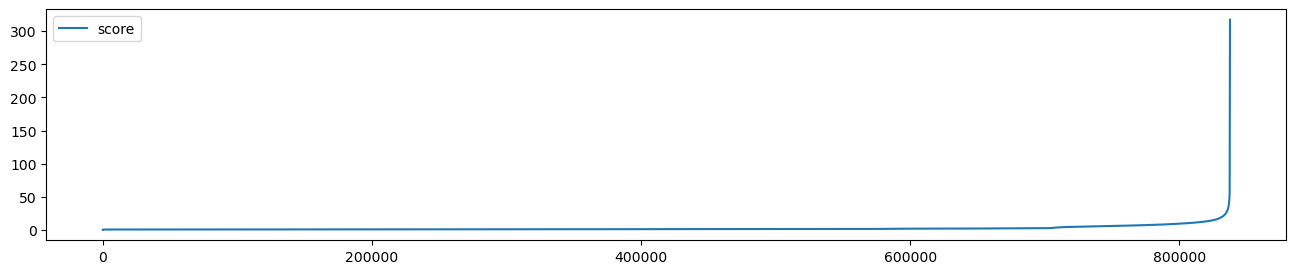

In [31]:
# section_len >> score
wiktionary = pak.rename_col(wiktionary,'section_len','score')

# page_part 0 aufwerten
mask = (wiktionary.lemma == wiktionary.section_id2)
wiktionary.loc[mask,'score'] = wiktionary[mask].score * 3

wiktionary['score'] = pak.scale( wiktionary.score, 'compare_median')
mask = wiktionary.score < 0.01
wiktionary.loc[mask,'score'] += 0.01

%matplotlib inline
a = wiktionary.score.sort_values().reset_index(drop=True)
pak.plot(a)

In [32]:
grid(wiktionary, pak.sample)

11 rows out of 837593


## Steuertabellen laden

In [33]:
blab.help(plan_merkmal_erstellen)

<class 'IPython.core.display.Markdown'>


<span style="font-size:larger;">plan_merkmal_erstellen():</span>

* definiert in Steuertabellen/s01_Steuertabellen.py
* `merkmal`: Name des Merkmals
* `template`: Name des Mediawiki-Templates, das diese Information enthält
* `collect`: Extractionsmethode
   * L extrahiert nur Links 
   * T extrahiert komplette Text-Absätze
   * Ü extrahiert Übersetzungen
   * P extrahiert Template-Parameter (Substring reicht)
   * E checkt nur auf Existenz
* `plan`:
   * 1: die Merkmale, die in wiktionary_merkmal gespeichert werden
   * 2: die Merkmale, die in wiktionary_merkmal_text gespeichert werden   
   * 3: Reihenfolge und Liste aller Merkmale aus flexion / übersicht <br>
        sowie die Merkmale aus named_entities und lexeme_manuell
* `sort`: Irgendwas zum Sortieren der Merkmale
* `is_lex`: Ist das Merkmal ein Lexem?    

In [34]:
# plan_merkmal Steuertabelle
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
grid(plan_merkmal)

103 rows


In [35]:
# translate_tag: Wortarten >> tags

try:
    del translate_tag
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tag)

180 rows


In [36]:
# translate_tagZ: tag >> tagZ und tagZZ

try:
    del translate_tagZ
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tagZ)

62 rows


In [37]:
# lex_test, lemma_test
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1)
grid(lemma_test)

80 rows loaded
Delete 21 rows from 80
48 rows


## Löschliste
* Excel-Datei aufbereiten
* wiktionary belöschen
* wiktionary_merkmal belöschen
* Falls löschliste und lexeme_manuell in Konflikt stehen, siegt lexeme_manuell. Es wird erst gelöscht und dann manuell ergänzt.

In [38]:
# Laden
löschliste = pak.load_excel( löschliste_filename )

379 rows loaded


In [39]:
# Format prüfen
löschliste['check'] = löschliste.isnull().sum(axis=1)
mask = löschliste.check != 2
error = check_mask(löschliste,mask,0, stop=False)
grid(löschliste,mask, color='green')

check_mask:  0 rows
No rows, mask filters them all away


In [40]:
löschliste = pak.drop_cols(löschliste,'check')
bpy.raise_if(error)

In [41]:
# Einzelne löschlisten

mask = löschliste.section_id2.notnull()
löschliste_section_id2 = list(löschliste[mask].drop_duplicates().section_id2)

mask = löschliste.lemma.notnull()
löschliste_lemma = list(löschliste[mask].drop_duplicates().lemma)

mask = löschliste.lex.notnull()
löschliste_lex = list(löschliste[mask].drop_duplicates().lex)
löschliste_lex += löschliste_lemma

In [42]:
# löschliste_lemma nach löschliste_section_id2 übertragen
mask1 =  wiktionary.title.isin(löschliste_lemma)   &   (wiktionary.title == wiktionary.lemma)
mask2 = ~wiktionary.section_id2.isin(löschliste_section_id2)
mask = mask1  &  mask2
#wiktionary[mask]
löschliste_section_id2 += list(wiktionary[mask].section_id2)

In [43]:
# wiktionary belöschen nach section_id2
mask = wiktionary.section_id2.isin(löschliste_section_id2)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_section_id2' )       # Löschen

Move 288 rows from 837593


In [44]:
# wiktionary belöschen nach lex
mask = wiktionary.title.isin(löschliste_lex)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_lex' )       # Löschen

Move 51 rows from 837305


In [45]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_section_id2')

mask = wiktionary_merkmal_trash.msg == 'löschliste_section_id2'
grid(wiktionary_merkmal_trash,mask)

Move 3563 rows from 3268495
3563 rows


In [46]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_lex')

mask = wiktionary_merkmal_trash.msg == 'löschliste_lex'
grid(wiktionary_merkmal_trash,mask)

Move 655 rows from 3264932
655 rows out of 4218


In [47]:
# aufräumen
del löschliste_lemma
del löschliste

## wiktionary tag und member
* Aus dem Feld pos entstehen die Felder tag (standardisiert) und member (vollständig)

In [48]:
# Kaputte Datenstruktur in str wandeln
wiktionary['tag'] = wiktionary.pos.apply( lambda x: str(x) )
wiktionary = pak.move_cols(wiktionary,'tag','pos')

# translate
translate_chars = str.maketrans("{}'[]:", "     ,")
wiktionary.tag = wiktionary.tag.str.translate(translate_chars)

# Liste ohne Dups draus machen
wiktionary.tag = wiktionary.tag.str.split(",")
wiktionary.tag = wiktionary.tag.apply( lambda x: list(set(x)) )

# Strings pflegen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e.strip().replace(' ','_')  for e in x ] )

# Leere Strings entfernen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e for e in x  if e != ''] )

In [49]:
#grid(wiktionary, pak.sample)

In [50]:
# nach Priorität sortieren (laut Steuertabellen)
wiktionary.loc[:,'tag'] = member_sortieren(wiktionary.tag) 

In [51]:
# In string wandeln
wiktionary.tag = wiktionary.tag.str.join(' ')

In [52]:
# translate_first

print(translate_first1)
print(translate_first2)

wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first1).str.strip()
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first2).str.strip()

[('  ', ' '), ('Partizip II', 'Ptz2'), ('Partizip_II', 'Ptz2'), ('PartizipII', 'Ptz2'), ('Konjunktiv II', 'Konj2'), ('Konjunktiv_II', 'Konj2'), ('KonjunktivII', 'Konj2'), ('  ', ' ')]
[('  ', ' '), ('Partizip I', 'Ptz1'), ('Partizip_I', 'Ptz1'), ('PartizipI', 'Ptz1'), ('Konjunktiv I', 'Konj1'), ('Konjunktiv_I', 'Konj1'), ('KonjunktivI', 'Konj1'), ('  ', ' ')]


In [53]:
#mask = (wiktionary.tag.str.count(' ') + 1)  > 2   
#wiktionary[mask]

In [54]:
grid(wiktionary, pak.sample)

11 rows out of 837254


In [55]:
pak.analyse_cols(wiktionary)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,837254,0,0,837254,0.0,418844.41,418843.5,837592.0,3.506792e+11
1,page_id,int64,np.int64,int64,pd.Int32,True,False,True,False,80.0 B,1,801783,0,35471,837254,0.0,622165.26,623174.5,1118318.0,5.209104e+11
2,page_part,int64,np.int64,int64,pd.Int8,True,False,True,False,80.0 B,1,7,0,837247,837254,0.0,0.04,0.0,6.0,3.743700e+04
3,section_id2,str,object,object,pd.string,False,True,True,True,797.0 B,1,837254,0,0,837254,&c.,NaN,NaN,μm,NaN
4,title,str,object,object,pd.string,False,True,True,True,795.0 B,1,801781,0,35473,837254,&c.,NaN,NaN,μm,NaN
5,lemma,str,object,object,pd.string,False,True,True,True,780.0 B,1,159400,0,677854,837254,&c.,NaN,NaN,μm,NaN
6,inflected,bool_,bool,bool,,True,False,True,True,10.0 B,1,2,0,837252,837254,0.0,0.83,NaN,1.0,6.968710e+05
7,pos,dict,object,object,,False,True,False,True,2.2 KB,1,161,0,837093,837254,NaN,NaN,NaN,NaN,NaN
8,tag,str,object,object,pd.string,False,True,True,True,709.0 B,1,155,0,837099,837254,Abkürzung,NaN,NaN,Wortverbindung Partikel,NaN
9,rhymes,list,object,object,,False,True,False,True,560.0 B,1,39528,526978,270748,837254,[a],NaN,NaN,"[ʏʃəs, yːʃəs]",NaN


In [56]:
# Spalte member bewahrt die ursprüngliche Klassifizierung vollständig
wiktionary['member'] = wiktionary.tag.copy()
wiktionary = pak.move_cols(wiktionary,'member','tag')

In [57]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 837254


In [58]:
grid(translate_tag)

180 rows


In [59]:
# anwenden
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

In [60]:
# Durchlauf2: translate_tag erneut anwenden 
mask = translate_tag.notiz.str.contains('Durchlauf2')
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag[mask] )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

In [61]:
# tag TODO für alles, was noch weiterverarbeitet werden muss
mask = (wiktionary.tag.str.len() == 0)
wiktionary.loc[mask,'tag'] = 'TODO'
#grid(wiktionary,mask)

In [62]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 837254


In [63]:
# Dekliniertes_Gerundivum: beizubehaltende
# VMaßeinheiten

## Bindestrich

In [64]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.section_id2.isin(suche)
check_mask(wiktionary,mask,0,4)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
wiktionary.loc[mask,'member']      = 'Adjektiv'
wiktionary.loc[mask,'tag']         = 'ADJA'
wiktionary.loc[mask,'pos']         = {'Adjektiv': []}
wiktionary.loc[mask,'section_id2'] = wiktionary[mask].section_id2.str.replace('-','_glex')
wiktionary[mask]

check_mask:  4 rows


,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,member,rhymes,score,flexion,ipa,syllables,lang,lang_code,error,lemma_lower
25872,68346,0,unter_glex,unter,unter,False,NaN,ADJA,Adjektiv,NaN,10.343864,{},[ʊntɐ],"[un, ter]",Deutsch,de,,unter
214016,380261,0,ober_glex,ober,ober,False,NaN,ADJA,Adjektiv,NaN,7.959903,{},[ˈoːbɐ],[ober],Deutsch,de,,ober
457256,681179,0,äußer_glex,äußer,äußer,False,NaN,ADJA,Adjektiv,NaN,12.086270,"{'Positiv': ['äußer(er)'], 'Superlativ': ['äuß...",[ˈɔɪ̯səʁɐ],NaN,Deutsch,de,,äußer
457269,681193,0,inner_glex,inner,inner,False,NaN,ADJA,Adjektiv,NaN,12.695018,"{'Positiv': ['inner(er)'], 'Superlativ': ['inn...",[ˈɪnɐ],NaN,Deutsch,de,,inner


In [65]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.section_id2.isin(suche)
check_mask(wiktionary_merkmal,mask,0,80)
wiktionary_merkmal.loc[mask,'section_id2'] = wiktionary_merkmal[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal[mask]

check_mask:  80 rows


In [66]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal_text
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal_text.section_id2.isin(suche)
check_mask(wiktionary_merkmal_text,mask,0,46)
wiktionary_merkmal_text.loc[mask,'section_id2'] = wiktionary_merkmal_text[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal_text[mask]

check_mask:  46 rows


In [67]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.lemma.isin(suche)
check_mask(wiktionary,mask,0,36)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
#grid(wiktionary,mask)

check_mask:  36 rows


In [68]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.data.isin(suche)
check_mask(wiktionary_merkmal,mask,0,10)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.replace('-','')
wiktionary_merkmal[mask]

check_mask:  1 rows


,section_id2,merkmal,node_debug,node_kontext,data,num,meta
652252,unter-_1,übersicht,Deutsch Adjektiv Übersicht,Positiv,unter,,<NA>


In [69]:
# AFIX 588
mask0 = ~wiktionary.lemma.str.startswith('-')   
mask1 =  wiktionary.lemma.str.endswith('-')  
mask2 = ~wiktionary.lemma.str[0].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 700)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'AFIX ' + wiktionary[mask].tag

check_mask:  551 rows


In [70]:
# ZFIX
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 = ~wiktionary.lemma.str.endswith('-')
mask2 = ~wiktionary.lemma.str[-1].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 600)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'ZFIX ' + wiktionary[mask].tag

check_mask:  480 rows


In [71]:
# MFIX >> löschen
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 =  wiktionary.lemma.str.endswith('-') 
mask2 =  wiktionary.lemma.str.len() > 2
mask3 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3
check_mask(wiktionary, mask, 0, 4)
#grid(wiktionary, mask)
#analyse_freqs(wiktionary[mask], 'tag')
wiktionary, wiktionary_trash = pak.move_rows(df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='MFIX') 

check_mask:  4 rows
Move 4 rows from 837254


## wiktionary Einzelkorrekturen

In [72]:
# Beispiele anzeigen
mask = wiktionary.member.str.contains('VMaßeinheiten')
grid(wiktionary,mask, color=None)

No rows, mask filters them all away


In [73]:
# anschauen
a = pak.analyse_freqs( wiktionary, ['member', 'tag'], splits=[' ',None])
grid(a)

68 rows


In [74]:
# Einzelkorrekturen        
einzelkorrekturen = { 'viel'        : 'ADJA PIAT',  # war: ADJA ADV PIAT CARD
                      'zig'         : 'ADJA',
                      'bis'         : 'KOUS APPR',      
                      'derentwegen' : 'PDAT PRELAT',
                      'Fachleute'   : 'NN',
                      'Rheinland'   : 'NE',                 
}
for i,t in einzelkorrekturen.items():
    mask = (wiktionary.section_id2 == i)
    wiktionary.loc[mask,'tag'] = t

In [75]:
# pflege_tag_felder (schreibe tagZZ usw.)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

## named_entities

In [76]:
# laden
named_entities = pak.load_excel(named_entities_filename, tabcol='quelle')

4544 rows loaded


In [77]:
# Überblick
a = pak.analyse_freqs(named_entities, cols=['quelle','member','lemma'], splits=[None,' '])
grid(a)

3 rows


In [78]:
# Felder ergänzen
named_entities['title']       = named_entities.lemma
named_entities['lemma_lower'] = named_entities.lemma.str.lower() 
named_entities = pak.move_cols( named_entities, 'lemma_lower','lemma')

In [79]:
# section_id2
named_entities['section_id2'] = named_entities.lemma + '_' + named_entities.quelle.str[0].str.upper().copy()
named_entities['section_id2'] = named_entities.section_id2.str.replace(' ','_').copy()
named_entities = pak.move_cols(named_entities, ['section_id2','title'])

In [80]:
# Bekannte section_id2 aus wiktionary übertragen. Aber nur wenn der tag wirklich gleich ist.
mask = (wiktionary.lemma == wiktionary.title)  # wichtig
named_entities = pak.update_col(named_entities, wiktionary[mask], on=['lemma_lower','tag'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 2291 records less!
update_col: 1251 cells written into existing column


In [81]:
# drop_cols
named_entities = pak.drop_cols(named_entities,['sex_f', 'sex_m', 'Land', 'Stadt','quelle'])

In [82]:
# score erhöhen
named_entities.score += 1.0
named_entities.score *= 2.0

In [83]:
grid(named_entities, pak.sample)

7 rows out of 4544


In [84]:
# Dups?
mask = named_entities.section_id2.duplicated()
check_mask(named_entities,mask,0,0)

check_mask:  0 rows


In [85]:
?pak.cols_to_dict

Signature:
pak.cols_to_dict(
    df,
    col_dict='',
    cols_add=[],
    use_defaultdict=False,
    drop=True,
)
Docstring:
Moves columns into a dict or defaultdict.
This is 
* col_dict:         name of the target column. Can be empty, but may already contain a dict or defaultdict. 
* cols_add:         Columns to be packed.
* use_defaultdict:  Should a defaultdict be used as data structure? Otherwise keys can only occur once.
* drop:             Should the packed columns be dropped (>> move) or not (>> copy)?
File:      ~/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/aggregate.py
Type:      function


In [86]:
named_entities = pak.cols_to_dict(named_entities,col_dict='flexion',cols_add=['Genus','Nom Sg','Gen Sg',], use_defaultdict=True)
named_entities

,section_id2,title,lemma,lemma_lower,tag,member,score,flexion
0,Hagen,Hagen,Hagen,hagen,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Hagen'], 'Gen Sg'..."
1,Jordan,Jordan,Jordan,jordan,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Jordan'], 'Gen Sg..."
2,Menzel_V,Menzel,Menzel,menzel,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Menzel'], 'Gen Sg..."
3,Oswald_V,Oswald,Oswald,oswald,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Oswald'], 'Gen Sg..."
4,Reinhardt_V,Reinhardt,Reinhardt,reinhardt,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Reinhardt'], 'Gen..."
...,...,...,...,...,...,...,...,...
4539,Wolff,Wolff,Wolff,wolff,NE,Nachname,2.989899,"{'Nom Sg': ['Wolff'], 'Gen Sg': ['Wolffs']}"
4540,Wolter_N,Wolter,Wolter,wolter,NE,Nachname,2.989899,"{'Nom Sg': ['Wolter'], 'Gen Sg': ['Wolters']}"
4541,Zander_2,Zander,Zander,zander,NE,Nachname,2.989899,"{'Nom Sg': ['Zander'], 'Gen Sg': ['Zanders']}"
4542,Zeller_N,Zeller,Zeller,zeller,NE,Nachname,2.989899,"{'Nom Sg': ['Zeller'], 'Gen Sg': ['Zellers']}"


In [87]:
grid(named_entities, pak.sample)

5 rows out of 4544


In [88]:
# anfügen
wiktionary = pak.add_rows(wiktionary, named_entities, assert_subset=True)

4544 rows added, now a total of 841794


In [89]:
# flexion type korrekt?
assert pak.ntypes(wiktionary.flexion) == 1

In [90]:
# wiktionary anschauen
mask = wiktionary.title.isin(suche_debug) 
r = wiktionary[mask].sort_values(['title','section_id2'])
grid(r)

3 rows


## Zahlwörter

In [91]:
# Wandelt eine Zahl in Worte um
def zahl_in_worten(n, s=True, z=False):
    
    w1 = "null ein zwei drei vier fünf sechs sieben acht neun zehn elf zwölf dreizehn vierzehn fünfzehn sechzehn siebzehn achtzehn neunzehn".split()
    w2 = "zwanzig dreißig vierzig fünfzig sechzig siebzig achtzig neunzig".split()    
    if n < 0: raise ValueError
    if n == 0 and z: return ""
    if n == 1 and s: return "eins"
    if n < 20: return w1[n]
    if n < 100:
        w = w2[(n - 20) // 10]
        if n % 10:
            w = w1[n % 10] + "und" + w
        return w
    if n < 1000:
        return w1[n // 100] + "hundert" + zahl_in_worten(n % 100, z=True)
    if n < 1000000:
        return zahl_in_worten(n // 1000, s=False) + "tausend" + zahl_in_worten(n % 1000, z=True)
    raise ValueError

In [92]:
print(zahl_in_worten(3107))

dreitausendeinhundertsieben


In [93]:
def zahlwörter_liste(range_): 
    return [ 
    {'lex' : [zahl_in_worten(z), str(z)], 
     'lemma' : zahl_in_worten(z),      
     'def'   : str(z),
    } for z in range_]

zahlwörter_liste(range(0,20,10))

[{'lex': ['null', '0'], 'lemma': 'null', 'def': '0'},
 {'lex': ['zehn', '10'], 'lemma': 'zehn', 'def': '10'}]

In [94]:
# 0..99 zahlwörter_a erzeugen
range_ = range(0,100)
zahlwörter_a = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_a

In [95]:
# Hunderter Zahlwörter erzeugen
range_ = range(100,1000,100)
zahlwörter_b = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_b

In [96]:
# Tausender Zahlwörter erzeugen
range_ = range(1000,99001,1000)
zahlwörter_c = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_c

In [97]:
# Zehntausender Zahlwörter erzeugen
range_ = range(10000,99001,10000)
zahlwörter_d = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_d

In [98]:
# Hunderttausender Zahlwörter erzeugen
range_ = range(100000,990001,100000)
zahlwörter_e = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_e

In [99]:
# concat
zahlwörter_all = pd.concat([  zahlwörter_a, zahlwörter_b, zahlwörter_c, zahlwörter_d, zahlwörter_e,  ])

In [100]:
# explode lex
zahlwörter_all = zahlwörter_all.explode('lex')

In [101]:
# Sonstige Spalten
zahlwörter_all['tag']         = 'CARD'
zahlwörter_all['tag_lex']     = 'lex' # ja
zahlwörter_all['genus']       = 'f'
zahlwörter_all['member']      = 'Zahlwort'
zahlwörter_all['tab']         = 'Zahlwort' # Wird später wieder gelöscht, dient der Kompatibilität zu lexeme_manuell

In [102]:
# Substantive ergänzen
mask = zahlwörter_all.lex == zahlwörter_all.lemma
df = zahlwörter_all[mask].copy()
df['lex']   = df.lex.str.capitalize()
df['lemma'] = df.lex.str.capitalize()
df['tag']   = 'NN'
zahlwörter_all = pak.add_rows(zahlwörter_all, df)
#df

226 rows added, now a total of 678


In [103]:
# zahlwörter_all anschauen
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


## lexeme_manuell

In [104]:
# laden
lexeme_manuell = pak.load_excel( lexeme_manuell_filename, tabcol='tab' )
lexeme_manuell = pak.move_cols(  lexeme_manuell, 'tag_lex')

1794 rows loaded


In [105]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,genus,tab
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,<NA>,<NA>,Partizipien
90,Ptz2,mißraten,missraten,VVFIN,<NA>,<NA>,Partizipien
204,Ptz2,missraten,missraten,VVFIN,<NA>,<NA>,Partizipien


In [106]:
# Partizipien falsch definiert?
mask1  = lexeme_manuell.tag_lex.str.startswith('Ptz')
mask2A = lexeme_manuell.tab != 'Partizipien'
mask2B = lexeme_manuell.tag != 'VVFIN'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask,0)
#lexeme_manuell[mask]

check_mask:  0 rows


In [107]:
# Abkürzungen falsch definiert?
# Das Schlüsselwort 'Abkürzung' darf nirgends in lexeme_manuell vorkommen.
mask1A = lexeme_manuell.member.str.contains('Abkürzung')
mask1B = lexeme_manuell.member.str.contains('Abkürzung')
mask = (mask1A | mask1B) 
check_mask(lexeme_manuell,mask,0)
lexeme_manuell[mask]

check_mask:  0 rows


,tag_lex,lex,lemma,tag,member,genus,tab


In [108]:
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


In [109]:
# assert subset
assert set(zahlwörter_all.columns) - set(['def']) <= set(lexeme_manuell.columns)

In [110]:
# zahlwörter_all anfügen
lexeme_manuell = pak.add_rows(lexeme_manuell, zahlwörter_all)

678 rows added, now a total of 2472


In [111]:
# tab analysieren
pak.analyse_freqs( lexeme_manuell, cols='tab')

,tab,tab_count,tab_percent,graph
0,esszett,729,29.5,##############
1,Zahlwort,678,27.4,#############
2,Partizipien,414,16.7,########
3,Diverses,299,12.1,######
4,Abkuerzungen,156,6.3,###
5,FM,102,4.1,##
6,Symbole,48,1.9,
7,Partikel,44,1.8,
8,Namen,2,0.1,


In [112]:
# NaN

# def
lexeme_manuell['def'] = lexeme_manuell['def'].fillna('')

# member
mask = lexeme_manuell.member.isnull()   |   lexeme_manuell.member.isin(['nan'])
lexeme_manuell.loc[mask,'member'] = ''
lexeme_manuell.member += ' manuell'

# lemma und lex
mask = lexeme_manuell.lemma.isnull()   |   lexeme_manuell.lemma.isin(['nan',''])
lexeme_manuell.loc[mask,'lemma'] = lexeme_manuell[mask].lex
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

mask = lexeme_manuell.lex.isnull()   |   lexeme_manuell.lex.isin(['nan',''])
lexeme_manuell.loc[mask,'lex'] = lexeme_manuell[mask].lemma
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

# genus
mask = lexeme_manuell.genus.isnull()   |   lexeme_manuell.genus.isin(['nan'])
lexeme_manuell.loc[mask,'genus'] = ''

# tag_lex
mask = lexeme_manuell.tag_lex.isnull()   |   lexeme_manuell.tag_lex.isin(['nan'])
lexeme_manuell.loc[mask,'tag_lex'] = ''

mask = (lexeme_manuell.lex != lexeme_manuell.lemma)   &   (lexeme_manuell.tag_lex == '')
lexeme_manuell.loc[mask,'tag_lex'] = 'lex'

mask = (lexeme_manuell.lex == lexeme_manuell.lemma)   &   (  (lexeme_manuell.tag_lex == 'lex')  | (lexeme_manuell.tag_lex == '')  )
lexeme_manuell.loc[mask,'tag_lex'] = 'lemma'

# tag
mask = lexeme_manuell.tag.isnull()   |   lexeme_manuell.tag.isin(['nan',''])
check_mask( lexeme_manuell, mask, 0, 0)

# Abschluss
lexeme_manuell.member = lexeme_manuell.member.str.strip()
lexeme_manuell = pak.rename_col(lexeme_manuell, 'genus','Genus')

#lexeme_manuell = pak.move_cols(lexeme_manuell, ['Genus','abk'], -1)
#lexeme_manuell['abk'] = ''

check_mask:  0 rows


In [113]:
# Dups löschen
mask = lexeme_manuell.duplicated()
lexeme_manuell, df = pak.move_rows(lexeme_manuell,mask)
grid(df)

Move 104 rows from 2472
104 rows


In [114]:
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lex,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


In [115]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [116]:
# strip
for c in lexeme_manuell.columns:
    lexeme_manuell[c] = lexeme_manuell[c].str.replace('  ',' ').str.strip()

In [117]:
# member analysieren
pak.analyse_freqs( lexeme_manuell, cols='member', splits=' ')

,member,member_count,member_percent,graph
0,manuell,2368,57.1,############################
1,lexAlt,653,15.7,#######
2,Zahlwort,651,15.7,#######
3,ergänzt,345,8.3,####
4,Einheit,56,1.3,
5,PRE,42,1.0,
6,Wortverbindung,28,0.7,
7,Ort,2,0.0,
8,modal,1,0.0,
9,Land,1,0.0,


In [118]:
# Derzeit nicht nötig: Ersetzungen im member
r = {  'Partizip1'          :  'Ptz1',        
       'Partizip_1'         :  'Ptz1',       
       'Partizip2'          :  'Ptz2',        
       'Partizip_2'         :  'Ptz2',   
       'Abkürzungen'        :  'Abkürzung',      
       'Abkürzung Abkürzung':  'Abkürzung',        
    }
lexeme_manuell['member'] = pak.replace_str(lexeme_manuell.member, r)
#grid(lexeme_manuell)

In [119]:
# Partizipien: tag_lex setzen 
mask = lexeme_manuell.member.str.contains('Ptz1')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz1'

mask = lexeme_manuell.member.str.contains('Ptz2')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz2'

In [120]:
# These: Auch member muss gesetzt werden, weil Partizipien ja doppelt eingetragen werden
# NEIN: Das Partizip wandert ja nach flexion
#mask1 =  lexeme_manuell.tag_lex.str.startswith('Ptz')
#mask2 = ~lexeme_manuell.member.str.contains('Ptz1')
#mask3 = ~lexeme_manuell.member.str.contains('Ptz2')
#mask = mask1  &  mask2  &  mask3
#lexeme_manuell.loc[mask,'member'] = lexeme_manuell[mask].member + ' ' + lexeme_manuell[mask].tag_lex
#grid(lexeme_manuell[mask])

In [121]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [122]:
# Tab Esszett: tag_lex setzen
mask1 = lexeme_manuell.tab == 'esszett'
mask2A = lexeme_manuell.tag_lex == ''
mask2B = lexeme_manuell.tag_lex == 'lex'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'tag_lex'] = 'lexAlt'

check_mask:  653 rows


In [123]:
# Tab Esszett: member setzen
mask1 =  lexeme_manuell.tab == 'esszett'
mask2 = ~lexeme_manuell.member.str.contains('lexAlt')
mask = mask1  &  mask2
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'member'] += 'lexAlt'

check_mask:  0 rows


In [124]:
# Tab Abkuerzungen: tag_lex setzen
mask = (lexeme_manuell.tab == 'Abkuerzungen')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

mask = lexeme_manuell.member.str.contains('Abkürzung')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

In [125]:
# anschauen
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lexAlt,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


In [126]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [127]:
# tag_lex analysieren
r = pak.analyse_freqs(lexeme_manuell, ['tag_lex', 'lex', 'member'], splits=[None,None,' '])
grid(r)

11 rows


In [128]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [129]:
# Kopie erzeugen, verwenden wir später um alle Partizipien als Adjektive einpflegen zu können
lexeme_manuell_copy = lexeme_manuell.copy()

In [130]:
# Spalte flexion erstellen
lexeme_manuell['lex_bak'] = lexeme_manuell.lex.copy()
lexeme_manuell = pak.implode_to_defaultdict(lexeme_manuell, col_key='tag_lex', col_value='lex', col_result='flexion')

0 rows less, now 2368 rows


In [131]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,lex_bak,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,gefriergetrocknet,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,missraten,{'Ptz2': ['missraten']}
1546,missraten,VVFIN,manuell,,Partizipien,,mißraten,{'Ptz2': ['mißraten']}


In [132]:
# lex == lemma: flexion soll leeres defaultdict sein
mask = (lexeme_manuell.lex_bak == lexeme_manuell.lemma) 
lexeme_manuell.loc[mask,'flexion'] = lexeme_manuell[mask].flexion.apply(lambda x: defaultdict(list))  # auf leeres defaultdict setzen
lexeme_manuell = pak.drop_cols(lexeme_manuell, 'lex_bak')
#grid(lexeme_manuell,~mask)

In [133]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,{}
1546,missraten,VVFIN,manuell,,Partizipien,,{'Ptz2': ['mißraten']}


In [134]:
# Weitere Spalten in flexion verpacken (mit cols_to_defaultdict
lexeme_manuell = pak.cols_to_defaultdict(  lexeme_manuell, col_dict='flexion', cols_add=['Genus','def']   )  

In [135]:
# Spalte tab brauchen wir nicht mehr >> löschen
lexeme_manuell = pak.drop_cols(lexeme_manuell, ['tab'])

In [136]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,flexion
1329,gefriertrocknen,VVFIN,manuell,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,{}
1546,missraten,VVFIN,manuell,{'Ptz2': ['mißraten']}


In [137]:
# gruppieren
lexeme_manuell = pak.group_and_agg(lexeme_manuell,
                               ['lemma', 'tag',   'member',              'flexion',            ],
                               ['group', 'group',  pak.agg_words_nodup,  pak.agg_defaultdicts, ],
                               ['lemma', 'tag',   'member',              'flexion',            ]
                              )

577 rows less, now 1791 rows


In [138]:
# Felder ergänzen
lexeme_manuell['title']       = lexeme_manuell.lemma
lexeme_manuell['lemma_lower'] = lexeme_manuell.lemma.str.lower() 
lexeme_manuell = pak.move_cols( lexeme_manuell, 'lemma_lower','lemma')

In [139]:
# tagZ und tagZZ ermitteln
lexeme_manuell = pflege_tag_felder(lexeme_manuell, translate_tagZ)

In [140]:
# anschauen
grid(lexeme_manuell, pak.sample_100)

100 rows out of 1791


In [141]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1090,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,6hpvSIfSNJ,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']},gefriertrocknen
1235,missraten,missraten,VVFIN,VVFIN,1UTc7XUuvl,VER,V,manuell,{'Ptz2': ['mißraten']},missraten


In [142]:
# anschauen: mehr als ein tag
mask = (lexeme_manuell.tag.str.split().str.len() > 1)
lexeme_manuell[mask]

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1635,welch,welch,PRELS PWAT,PRELS,PWAT,PRO,P,manuell,"{'lex': ['welche', 'welchem', 'welchen', 'welc...",welch


In [143]:
# section_id2 schreiben
lexeme_manuell['section_id2'] = lexeme_manuell.lemma.str.replace(' ','_') + '_M'
mask = lexeme_manuell.tag == 'CARD'
lexeme_manuell.loc[mask,'section_id2'] = lexeme_manuell[mask].lemma.str.replace(' ','_') + '_Z'
lexeme_manuell = pak.move_cols(lexeme_manuell, ['section_id2','title'])

In [144]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen_M,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,6hpvSIfSNJ,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten_M,missraten,missraten,missraten,VVFIN,VVFIN,1UTc7XUuvl,VER,V,manuell,{'Ptz2': ['mißraten']}


In [145]:
#wiktionary

In [146]:
# Bekannte section_id2 aus wiktionary übertragen

mask = (wiktionary.lemma == wiktionary.title)  # wichtig! Gerade die Datensätze, die nicht darunter fallen, verursachen Probleme bei Partizipien.

# tagZZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZZ'], col='section_id2',  col_score='score'  )

#tagZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZ'],  col='section_id2',  col_score='score'  )

# tag
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tag'],   col='section_id2',  col_score='score'  )

# Wenn ein sinnvoller tag fehlt, reicht lemma
mask = (wiktionary.lemma == wiktionary.title)   &   wiktionary.tag.str.contains('TODO')
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 3340 records less!
update_col: 1193 cells written into existing column
update_col: col_score score applied, 2322 records less!
update_col: 1169 cells written into existing column
update_col: col_score score applied, 3542 records less!
update_col: 1154 cells written into existing column
update_col: col_score score applied, 4 records less!
update_col: 34 cells written into existing column


In [147]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,6hpvSIfSNJ,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten,missraten,missraten,missraten,VVFIN,VVFIN,1UTc7XUuvl,VER,V,manuell,{'Ptz2': ['mißraten']}


In [148]:
# anschauen
#grid(lexeme_manuell, pak.sample_100)

In [149]:
# anfügen
wiktionary = pak.add_rows(wiktionary, lexeme_manuell, assert_subset=True)

1791 rows added, now a total of 843585


In [150]:
# section_id2 ist jetzt nicht mehr eindeutig
mask = wiktionary.duplicated(subset=['section_id2'], keep=False)
check_mask(wiktionary,mask,4517) 
#a = wiktionary[mask].sort_values(['section_id2'])
#grid(a)

check_mask:  4930 rows


In [151]:
assert pak.ntypes(wiktionary.flexion) == 1

In [152]:
# wiktionary suche_debug
#grid(search_str(wiktionary, suche_debug))

## ipa, syllables & rhymes

In [153]:
# Datentypen sind in jeder Zeile gleich
assert pak.ntypes(wiktionary.ipa) == 1
assert pak.ntypes(wiktionary.syllables) == 1

In [154]:
# Listen zu Strings
mask = ~wiktionary.ipa.isnull()
wiktionary.loc[mask,'ipa'] = wiktionary[mask].ipa.str[0]

mask = ~wiktionary.syllables.isnull()
wiktionary.loc[mask,'syllables'] = wiktionary[mask].syllables.str.join('⇀')

mask = ~wiktionary.rhymes.isnull()
wiktionary.loc[mask,'rhymes'] = wiktionary[mask].rhymes.str[0]

In [155]:
# cols_to_defaultdict
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion', cols_add=['ipa','syllables','rhymes']  )

In [156]:
# wiktionary anschauen
grid(wiktionary, pak.sample)

13 rows out of 843585


## flexion nach wiktionary_merkmal exploden
* hiernach muss die löschliste nochmal angewendet werden

In [ ]:
# flexion: vorbereiten
mask1 = wiktionary.flexion.notnull() 
mask2 = wiktionary.flexion != {}
mask3 = wiktionary.flexion != defaultdict(list)
mask = mask1  &  mask2  &  mask3 

spalten = ['section_id2','flexion']
df = pak.explode_dict(wiktionary[spalten][mask], col_dict='flexion', col_key='node_kontext', col_value='data', from_defaultdict=True)
df['merkmal'] = 'flexion'

In [ ]:
# Beispiel anschauen
mask = df.section_id2 == suche_debug[0]
grid(df,mask)

In [ ]:
#bpy.minivenn(wiktionary_merkmal.columns, df.columns)

In [ ]:
# an wiktionary_merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df, assert_subset=True)
wiktionary   = pak.drop_cols(wiktionary, ['flexion'])  

In [ ]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2.isin(suche_debug)
grid(wiktionary_merkmal,mask)

## wiktionary in 3 Teile aufteilen

In [ ]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

In [ ]:
# pflege_tag_felder (zur Sicherheit noch mal)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

In [ ]:
# LEX-Kennzeichnung sollte eineindeutig sein, außer bei FIX
mask = wiktionary.tag.str.contains('LEX_')   &   wiktionary.tag.str.contains(' ')   &   ~wiktionary.tag.str.contains('FIX')
#grid(wiktionary,mask)
check_mask(wiktionary,mask, 0, 0)

### wiktionary_partizip
* Enthält Partizipien in Form von Partizipialadjektiven
* Aber keine Verben mit Partizip-Lexem!

In [ ]:
# Partizipien nach wiktionary_partizip abspalten
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.member.str.contains('Ptz')  
mask = mask1  &  mask2
wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

In [ ]:
## verblieben in wiktionary
mask1 = (wiktionary.lemma == wiktionary.title)  
mask2 = wiktionary.lemma.isin(suche_debug) 
mask = mask1 & mask2
wiktionary[mask]

In [ ]:
## jetzt in wiktionary_partizip
mask = wiktionary_partizip.lemma.isin(suche_debug) 
wiktionary_partizip[mask]

In [ ]:
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.lemma.isin(wiktionary_partizip.lemma) 
mask = mask1  &  mask2
wiktionary[mask]
#wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

### wiktionary_nolemma

In [ ]:
wiktionary_nolemma       = wiktionary.head(0)
wiktionary_nolemma_trash = wiktionary.head(0)

In [ ]:
# LEX-Datensätze nach wiktionary_nolemma verschieben
mask = wiktionary.tag.str.contains('LEX_')    
check_mask(wiktionary,mask,639734)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='tag_LEX' )  

In [ ]:
# auch nach wiktionary_nolemma verschieben
mask = wiktionary.member.str.contains('Deklinierte_Form')   # 2 Datensätze
check_mask(wiktionary, mask, 0, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='member_Deklinierte_Form' )  

In [ ]:
# auch nach wiktionary_nolemma verschieben
mask = (wiktionary.title != wiktionary.lemma)               # Es waren mal 10 Datensätze, jetzt sind es 5501
check_mask(wiktionary, mask, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='title_ungleich_lemma' )  

In [ ]:
# wiktionary suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

In [ ]:
# wiktionary_nolemma: Spalten pflegen
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'title', 'lex')
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'section_id2','nolemma_id')
wiktionary_nolemma = pak.drop_cols(wiktionary_nolemma, ['pos','tag_anz','ipa','syllables','msg','page_id','page_part','inflected','rhymes'])
#wiktionary_nolemma = pak.rename_col( wiktionary_nolemma, 'tag_0', 'tag') # Jetzt gibt es definitiv keine Mehrfachtags mehr

In [ ]:
# anschauen
pak.sample(wiktionary_nolemma)

### wiktionary_lemma

In [ ]:
# wiktionary_lemma: erstellen und Spalten pflegen
wiktionary_lemma       = pak.drop_cols(wiktionary, ['title','pos'])
wiktionary_lemma_trash = wiktionary_lemma.head(0)

In [ ]:
del wiktionary

In [ ]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma, suche_debug))

## Partizipien
Die Partizipien werden<br> 
a) an wiktionary_merkmal angefügt (als Partizip-Flexion des Verbs)<br> 
b) an wiktionary_lemma angefügt   (als Adjektiv mit member Partizip)

Danach findet sich alles aus wiktionary in wiktionary_lemma und wiktionary_nolemma

### wiktionary_partizip pflegen

In [ ]:
# rename_col
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'section_id2', 'adjektiv_id' )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'title',       'adjektiv'    )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'lemma',       'verb'        )

#wiktionary_partizip = pak.move_cols(wiktionary_partizip,'verb_lower','verb')

In [ ]:
# drop_cols
lösche_spalten = ['pos','error','lang','lang_code','lemma_lower','inflected','tag_0','tag_1']
wiktionary_partizip = pak.drop_cols(wiktionary_partizip,lösche_spalten)

In [ ]:
# change_datatype
wiktionary_partizip = pak.change_datatype(wiktionary_partizip)

In [ ]:
# falsche Partizipien löschen
falsche_partizipien = ['sehen','hören','wollen','lassen','mögen','sollen',]
mask = wiktionary_partizip.adjektiv.isin(falsche_partizipien) 
check_mask(wiktionary_partizip, mask, 0, 6)
wiktionary_partizip, df = pak.move_rows(wiktionary_partizip, mask)
df

In [ ]:
#grid(wiktionary_partizip)

In [ ]:
# wiktionary suche_debug
grid(search_str(wiktionary_partizip, suche_debug))

In [ ]:
# So sehen normale Partizipien 1 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz1')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

In [ ]:
# Dies sind kaputte Partizipien 1: Das verb ist falsch, kann aber leicht korrigiert werden
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 =  wiktionary_partizip.member.str.contains('Ptz1')
mask3 =  wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 =  wiktionary_partizip.verb.str.endswith(('end','ernd'))
mask = mask1  &  mask2  &  mask3  &  mask4

wiktionary_partizip.loc[mask,'verb'] = wiktionary_partizip[mask].verb.str[:-1]
grid(wiktionary_partizip,mask)

In [ ]:
# So sehen normale Partizipien 2 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

In [ ]:
# Dies sind kaputte Partizipien 2: Das verb ist falsch, kann auch nicht gut korrigiert werden.
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask3 = wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 = wiktionary_partizip.verb.str.endswith('t')
mask = mask1  &  mask2  &  mask3  &  mask4
grid(wiktionary_partizip,mask)

In [ ]:
# Kaputte Partizipien 2 löschen
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip = pak.drop_rows(wiktionary_partizip,mask)

In [ ]:
# Gibt es weitere kaputte Partizipien?
mask = ~wiktionary_partizip.verb.str.endswith(verbendungen)
check_mask(wiktionary_partizip,mask,0)
#grid(wiktionary_partizip,mask)

In [ ]:
# Wenn es verb nicht auch als Wort gibt, dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = ~wiktionary_partizip.verb.isin(wiktionary_lemma.lemma)
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

In [ ]:
mask = wiktionary_lemma.tagZZ == 'V'
pak.analyse_freqs( wiktionary_lemma[mask], ['tag', 'member'])
#wiktionary_lemma[mask]

In [ ]:
# verb_id ermitteln
mask = wiktionary_lemma.tagZZ == 'V'
wiktionary_partizip = pak.update_col( wiktionary_partizip,  wiktionary_lemma[mask], 
                                      left_on='verb',       right_on='lemma', 
                                      col_rename='verb_id', col='section_id2',    
                                                            col_score='score' 
                                    )
wiktionary_partizip = pak.move_cols(wiktionary_partizip, 'verb_id','adjektiv')

In [ ]:
# keine verb_id? Dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = wiktionary_partizip.verb_id.isnull()
check_mask(wiktionary_partizip,mask,0,5)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

In [ ]:
# member pflegen. Enthält danach genau Ptz1 x-oder Ptz2.
wiktionary_partizip['member'] = pak.remove_str(wiktionary_partizip.member,['Adjektiv','Wortverbindung'])
mask = ~wiktionary_partizip.member.isin(['Ptz1','Ptz2'])
check_mask(wiktionary_partizip,mask,0)
mask = wiktionary_partizip.member.isnull()  |  (wiktionary_partizip.member=='')
check_mask(wiktionary_partizip,mask,0)

In [ ]:
# Dups sollten eigentlich nicht drin sein
mask = wiktionary_partizip.duplicated()
check_mask(wiktionary_partizip,mask,0)

In [ ]:
# wiktionary_partizip.member analysieren
#r = pak.analyse_freqs( wiktionary_partizip, ['member', 'verb','adjektiv'])
#r

In [ ]:
mask = wiktionary_partizip.adjektiv.isin(['betroffen','dienend'])
wiktionary_partizip[mask]

### Partizipien als Flexion des Verbs eintragen

In [ ]:
#wiktionary_merkmal

In [ ]:
# wiktionary_merkmal_partizip
wiktionary_merkmal_partizip = wiktionary_partizip.copy()
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'member',      'merkmal')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'verb_id',     'section_id2')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv_id', 'data_id')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv',    'data')
wiktionary_merkmal_partizip = pak.drop_cols(wiktionary_merkmal_partizip,['tag','tagZ','tagZZ','score','verb','page_id','page_part'])
wiktionary_merkmal_partizip = pak.move_cols(wiktionary_merkmal_partizip,['section_id2','merkmal'])
assert set(wiktionary_merkmal_partizip.columns) == set(['section_id2','merkmal','data_id','data'])
pak.sample(wiktionary_merkmal_partizip)

In [ ]:
# wiktionary_partizip suche_debug
search_str(wiktionary_merkmal_partizip, suche_debug)

In [ ]:
# wiktionary_merkmal_partizip als merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, wiktionary_merkmal_partizip)

### Partizipien als Adjektiv einpflegen

In [ ]:
wiktionary_partizip.head(1)

In [ ]:
wiktionary_lemma.head(1)

In [ ]:
# wiktionary_lemma_partizip
wiktionary_lemma_partizip = wiktionary_partizip.copy()
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv_id',     'section_id2')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv',        'lemma')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'verb_id',         'data_id')
wiktionary_lemma_partizip = pak.drop_cols(wiktionary_lemma_partizip, ['verb'] )
wiktionary_lemma_partizip = ergänze_felder(wiktionary_lemma_partizip)
wiktionary_lemma_partizip = pflege_tag_felder(wiktionary_lemma_partizip, translate_tagZ)

pak.sample(wiktionary_lemma_partizip)

In [ ]:
# Einige ungeeignete Partizipien löschen
mask1 = ~wiktionary_lemma_partizip.lemma.str.endswith(('d','t','en'))
mask2 = ~wiktionary_lemma_partizip.lemma.isin(['vertan',])
mask = mask1  &  mask2
check_mask(wiktionary_lemma_partizip,mask,37)
wiktionary_lemma_partizip, df = pak.move_rows(wiktionary_lemma_partizip,mask)
grid(df)

In [ ]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma_partizip, suche_debug))

In [ ]:
# wiktionary_lemma_partizip als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, wiktionary_lemma_partizip)

### Manuelle Partizipien als Adjektiv einpflegen

In [ ]:
# lexeme_manuell_copy als Basis
mask = lexeme_manuell_copy.tab == 'Partizipien'
ptz_manuell = lexeme_manuell_copy[mask]

In [ ]:
# id des Verbs holen (dirty)
ptz_manuell = pak.update_col(ptz_manuell, 
                             lexeme_manuell,
                             on=['lemma','tag'],  
                             col='section_id2',
                             col_rename='data_id'
                            )

In [ ]:
# Weitere Spalten
ptz_manuell['section_id2'] = ptz_manuell.lex.str.replace(' ','_') + '_MADJ'
spalten = ['section_id2','lex','tag_lex','data_id']
ptz_manuell = ptz_manuell[spalten]
ptz_manuell = pak.rename_col(ptz_manuell, 'lex',    'lemma')
ptz_manuell = pak.rename_col(ptz_manuell, 'tag_lex','member')

ptz_manuell['member'] += ' manuell'
ptz_manuell['tag'] = 'ADJA'
ptz_manuell['score'] = 0.5

ptz_manuell = ergänze_felder(ptz_manuell)
ptz_manuell = pflege_tag_felder(ptz_manuell, translate_tagZ)

#grid(ptz_manuell)

In [ ]:
# ptz_manuell suche_debug
grid(search_str(ptz_manuell, suche_debug))

In [ ]:
# section_id2 ermitteln
mask = wiktionary_lemma.tagZ == 'ADJ'
ptz_manuell = pak.update_col( ptz_manuell,  
                              wiktionary_lemma[mask], 
                              on='lemma',     
                              col='section_id2',    
                              col_score='score' 
                                    )
ptz_manuell

In [ ]:
# ptz_manuell als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, ptz_manuell)

In [ ]:
mask = wiktionary_merkmal.data_id != ''
wiktionary_merkmal[mask]

## wiktionary_lemma weiterbearbeiten

### Grundpflege

In [ ]:
# reset_index
wiktionary_lemma = pak.reset_index(wiktionary_lemma)

In [ ]:
# drop_cols
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,['msg','inflected','error','lang','lang_code'])

In [ ]:
# ergänze_felder
#from x32_Funktionen import *
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

In [ ]:
# fillna
wiktionary_lemma['score'] = wiktionary_lemma.score.fillna(0.45)
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
#pak.nnan(wiktionary_lemma)

## wiktionary_merkmal_text

In [ ]:
# ist scho geladen
# wiktionary_merkmal_text = pak.load_pickle(wiktionary_merkmal_text_filename)
assert not pak.any_nan(wiktionary_merkmal_text)
# pak.nnan(wiktionary_merkmal_text)

### Grundpflege

In [ ]:
# drop_cols
wiktionary_merkmal_text = pak.drop_cols( wiktionary_merkmal_text, ['section_id'])

In [ ]:
# wiktionary_merkmal_text: list_to_string
wiktionary_merkmal_text['num'] = pak.list_to_string(wiktionary_merkmal_text.num)

In [ ]:
# wiktionary_merkmal_text: drop_duplicates
vorher = wiktionary_merkmal_text.shape[0]
wiktionary_merkmal_text = wiktionary_merkmal_text.drop_duplicates()
nachher = wiktionary_merkmal_text.shape[0]
print(vorher-nachher,'Datensätze gelöscht')

In [ ]:
pak.sample(wiktionary_merkmal_text)

In [ ]:
# lemma übertragen
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
wiktionary_merkmal_text = pak.update_col( wiktionary_merkmal_text, wiktionary_lemma, on='section_id2', col='lemma'  )

In [ ]:
# verwaise_section_id2 finden
mask = wiktionary_merkmal_text.lemma.isnull()
verwaise_section_id2 = wiktionary_merkmal_text[mask].section_id2.drop_duplicates()
verwaise_section_id2

In [ ]:
bgc('orange') ## TODO_verwaiste_Wörter
mask1 =  wiktionary_merkmal_text.section_id2.isin(verwaise_section_id2)
mask2 = ~wiktionary_merkmal_text.section_id2.isin(wiktionary_trash.section_id2)
mask = mask1  &  mask2
grid(wiktionary_merkmal_text[mask].sort_values('section_id2'))

In [ ]:
# verwaiste Datensätze anschauen
mask = wiktionary_merkmal_text.lemma.isnull()
grid(wiktionary_merkmal_text,mask)

In [ ]:
# verwaiste Datensätze löschen
mask = wiktionary_merkmal_text.lemma.isnull()
check_mask(wiktionary_merkmal_text,mask,1217)
wiktionary_merkmal_text = pak.drop_rows(wiktionary_merkmal_text,mask)

In [ ]:
# suche_debug

mask = wiktionary_merkmal_text.lemma.isin(suche_debug)
wiktionary_merkmal_text[mask]
#wiktionary_lemma[mask].lemma

In [ ]:
# Grobreinigung 

r = { ' !':'!',  ' ?':'?',  ' ,':',',  ' en ':'en ',  ' e ':'e ',  ' en,':'en,',  ' e,':'e,',  ' es,':'es,',  '  ':' ', }
wiktionary_merkmal_text['data'] = pak.replace_str( wiktionary_merkmal_text.data, r )

r = ['[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]', '[10]', '[11]', '[12]', '[1a]', '[*]']
wiktionary_merkmal_text['data'] = pak.remove_str( wiktionary_merkmal_text.data, r )

In [ ]:
pak.nnan(wiktionary_lemma)

In [ ]:
#mask = wiktionary_merkmal_text.data.str.endswith(  ( ' e', ' en', ' es' )  )
#r = { ' e':'e',   ' en':'en',   ' es':'es',  }
#wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )
#grid(wiktionary_merkmal_text,mask)

### Aufzählungen in Einzeldatensätze aufsplitten
* Die merkmale bsp_re und bsp_sp enthalten Aufzählungen. Diese werden in Einzeldatensätze aufgesplittet. 
* Das Feld rank_merkmal erhält die Reihenfolge.

In [ ]:
# Splitten vorbereiten

mask = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
r = { '–':'➤',  '—':'➤',  ';':'➤',  '/':'➤',  }
wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )

grid( wiktionary_merkmal_text, mask )

In [ ]:
# rank_merkmal
wiktionary_merkmal_text = wiktionary_merkmal_text.reset_index() # spalte 'index' erzeugen
wiktionary_merkmal_text = pak.rank( wiktionary_merkmal_text, cols_group=['section_id2','merkmal'], col_score='index', find='min', col_target='rank_merkmal')
wiktionary_merkmal_text = pak.rename_col(wiktionary_merkmal_text,'index','i')
wiktionary_merkmal_text = pak.force_index(wiktionary_merkmal_text,'i')

In [ ]:
# zu splittende Datensätze abtrennen
mask1 = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
mask2 = wiktionary_merkmal_text.data.str.contains('➤')
mask  = mask1  &  mask2

wiktionary_merkmal_text, df = pak.move_rows( wiktionary_merkmal_text, mask, msg=None )

In [ ]:
# splitten
df['data'] = df.data.str.split('➤')
df = df.explode('data')

In [ ]:
df.head(5)

In [ ]:
# rank_merkmal2
df = df.reset_index()
df = pak.rank(df, cols_group=['section_id2','merkmal','rank_merkmal'], col_score='i', find='min', col_target='rank_merkmal2')
df = pak.force_index(df,'i')

In [ ]:
df.head(5)

In [ ]:
# wieder anfügen
wiktionary_merkmal_text = pak.add_rows(wiktionary_merkmal_text, df)
wiktionary_merkmal_text['rank_merkmal2'] = wiktionary_merkmal_text.rank_merkmal2.fillna(0) 

In [ ]:
# rank_merkmal endgültig schreiben
assert wiktionary_merkmal_text.rank_merkmal2.max() < 100
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal)
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal2)
wiktionary_merkmal_text['rank_merkmal'] = (wiktionary_merkmal_text.rank_merkmal * 100 + wiktionary_merkmal_text.rank_merkmal2).astype('int')
wiktionary_merkmal_text = pak.drop_cols(wiktionary_merkmal_text,['rank_merkmal2'])

In [ ]:
#mask = wiktionary_merkmal_text.merkmal.isin( ['bsp_re'] )
#grid(wiktionary_merkmal_text,mask)

## Preprocessing

In [ ]:
text = bj_nlp.TESTTEXT_0
text

In [ ]:
# Standardkonfiguration
bj_nlp.preprocess(text)

In [ ]:
a = 'Hej U+1F600 världen'
print(a)

In [ ]:
pak.analyse_datatypes(wiktionary_merkmal)

In [ ]:
# wiktionary_lemma
cols = pak.col_names(wiktionary_lemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_lemma.loc[:,feld] = wiktionary_lemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)       )

In [ ]:
# wiktionary_nolemma
cols = pak.col_names(wiktionary_nolemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_nolemma.loc[:,feld] = wiktionary_nolemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

In [ ]:
# wiktionary_merkmal

if gründlich:
    cols = pak.col_names(wiktionary_merkmal, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        print(feld)
        wiktionary_merkmal[feld] = wiktionary_merkmal[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

In [ ]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)
    #wiktionary_merkmal[mask]

In [ ]:
# wiktionary_merkmal_text

if gründlich:
    cols = pak.col_names(wiktionary_merkmal_text, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        wiktionary_merkmal_text[feld] = wiktionary_merkmal_text[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

## Sonderzeichen

In [ ]:
# Sonderfälle
#mask = wiktionary_merkmal.data.str.contains('{{')
r = { '{{NNBSP}}'   :   ' '  ,   
             "''"   :   ''   ,
    }
wiktionary_merkmal['data'] = pak.replace_str(wiktionary_merkmal.data, r)

In [ ]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

In [ ]:
# wiktionary_lemma enthält nicht_erlaubte_sonderzeichen (siehe Steuertabellen)
mask = wiktionary_lemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma)   &   ~wiktionary_lemma.section_id2.str.endswith('_M')
check_mask(wiktionary_lemma, mask, 0, 50)
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows(df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')

In [ ]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

In [ ]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lex.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lex_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

In [ ]:
# data remove_str
r = ['Verzeichnis:Deutsch/','Verzeichnis:','<sub>','</sub>','<sup>','</sup>','Wikipedia:de:','Wikipedia:',]
wiktionary_merkmal['data'] = pak.remove_str(wiktionary_merkmal.data, r )

In [ ]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('<',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('<').str[0]
#wiktionary_merkmal[mask]

In [ ]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('{',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('{').str[0]
#wiktionary_merkmal[mask]

In [ ]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.startswith(('http:','https:'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='data_startswith')

In [ ]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.lower().str.endswith(('.jpg','.png','.gif'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask,  msg='data_endswith')

In [ ]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.startswith(('mini|','thumb|','|'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_startswith')

In [ ]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.contains('px|', regex=False)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_contains')

In [ ]:
# wiktionary_merkmal enthält nicht_erlaubte_sonderzeichen
# >> löschen

felder = ['node_debug','node_kontext','meta','data'] 
for feld in felder: 
    mask = wiktionary_merkmal[feld].str.contains(nicht_erlaubte_sonderzeichen_gnädig) 
    print(feld)
    #check_mask(wiktionary_merkmal, mask, 0, 20)
    wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg= feld + '_sonderzeichen')
    

In [ ]:
assert not pak.any_nan(wiktionary_merkmal.data) 

In [ ]:
#mask = wiktionary_merkmal.data.isnull()
#grid(wiktionary_merkmal, mask, color='green')

In [ ]:
a = pak.analyse_freqs(wiktionary_merkmal_trash,['msg','data','meta'])
grid(a)

In [ ]:
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
#grid(wiktionary_merkmal_trash,mask)
grid(wiktionary_merkmal_trash,mask)

In [ ]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

## wiktionary_merkmal

### node_debug >> member
* member durch Daten aus der Spalte node_debug ergänzen

In [ ]:
# übersicht reinigen mit remove_str und replace_str
mask = (wiktionary_merkmal.merkmal == 'übersicht')
r = ['-sch', 'Bairisch','Deutsch', ' f',' m',' n', 'Übersicht']
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.remove_str(wiktionary_merkmal[mask].node_debug, r)

r = {'Pronomina-Tabelle': 'Pronomen', 'adjektivisch':'adjNN', 'Eigenname':'Name'}
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.replace_str(wiktionary_merkmal[mask].node_debug, r)

In [ ]:
mask = (wiktionary_merkmal.merkmal == 'übersicht')
a = pak.analyse_freqs(wiktionary_merkmal[mask], ['node_debug', 'section_id2'], splits=[' ',None])
a

In [ ]:
# member_plus festlegen
mask = (wiktionary_merkmal.merkmal == 'übersicht')   &   (wiktionary_merkmal.node_debug.str.len() > 0)
spalten = ['section_id2','node_debug']
df = wiktionary_merkmal[mask][spalten].drop_duplicates()
df.columns = ['section_id2','member_plus']
#grid(df,sample)

In [ ]:
# an member anhängen
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2',col='member_plus')
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.strip() + ' ' + wiktionary_lemma[mask].member_plus.str.strip()
wiktionary_lemma = pak.drop_cols(wiktionary_lemma, 'member_plus')

In [ ]:
# node_debug leeren
mask = (wiktionary_merkmal.merkmal == 'übersicht')
wiktionary_merkmal.loc[mask,'node_debug'] = ''

In [ ]:
# Letzte Löschungen
r = ['Wortart fehlt']
wiktionary_merkmal.node_debug = pak.remove_str( wiktionary_merkmal.node_debug, r )

In [ ]:
# node_debug löschen (müsste jetzt überall leer sein)
mask = (wiktionary_merkmal.node_debug.str.len() > 0)
if version == '_all':
    check_mask(wiktionary_merkmal, mask, 0, 0)
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_debug')   

### übersicht und flexion
* aus wiktionary_merkmal herausnehmen, pflegen und wieder anfügen

In [ ]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

In [ ]:
# nach flexion auslagern
mask = wiktionary_merkmal.merkmal.isin(['übersicht','flexion']) 
wiktionary_merkmal, flexion = pak.move_rows( wiktionary_merkmal, mask, msg=None ) 
flexion_trash = flexion.head(0)

In [ ]:
# In wiktionary_merkmal ist node_kontext jetzt überflüssig
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_kontext') 

In [ ]:
flexion = pak.rename_col(flexion, 'merkmal',      'quelle')
flexion = pak.rename_col(flexion, 'node_kontext', 'merkmal_lang')
flexion = pak.drop_cols(flexion, ['num','meta','msg','section_id','quelle'])
flexion['merkmal'] = flexion.merkmal_lang.copy()
flexion = pak.move_cols( flexion, ['section_id2', 'merkmal_lang', 'merkmal', 'data'])

In [ ]:
# Dups entfernen
flexion = pak.reset_index(flexion.drop_duplicates())

In [ ]:
# meta schreiben
# dazu lexeme_manuell nochmal aufklappen, um an die lexeme heranzukommen
df = pak.explode_dict(lexeme_manuell, col_dict='flexion', col_key='key', col_value='data', from_defaultdict=True)
mask = df.section_id2 == 'und'
df[mask]

In [ ]:
# meta schreiben
flexion['meta'] = ''
mask = pak.isin( flexion, df, on=['section_id2','data'])
check_mask(flexion,mask)
flexion.loc[mask,'meta'] = 'manuell'

In [ ]:
# TODO_Widersprüchliche_Angaben l
mask1 = pak.same_but_different(flexion, same=['section_id2','merkmal_lang'], different='data', return_mask=True)
mask2 = flexion.merkmal == 'Genus'
mask3 = flexion.section_id2 != 'Fräulein'
mask = mask1  &  mask2  &  mask3
check_mask(flexion, mask, 0, 20)
bgc('orange')

In [ ]:
grid(flexion[mask].sort_values(['section_id2']))

In [ ]:
# abspalten
flexion, df = pak.move_rows(flexion, mask, msg=None)

# auswählen
df = df.drop_duplicates(subset=['section_id2','merkmal'])

# wieder anfügen
flexion = pak.add_rows(flexion, df)

In [ ]:
# merkmal reinigen

# 'Ptz1' und 'Ptz2' maskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'Ptz1':'PtzA', 'Ptz2':'PtzB'})

# merkmal reinigen
r = ['*','1','2','3','4','stark','schwach','gemischt']
flexion['merkmal'] = pak.remove_str(flexion.merkmal, r)

# 'Ptz1' und 'Ptz2' demaskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'PtzA':'Ptz1', 'PtzB':'Ptz2'})

In [ ]:
# Beispiel anschauen
mask = flexion.section_id2 == suche_debug[0]
grid(flexion,mask)

In [ ]:
# translate_first

print(translate_first1)
print(translate_first2)

for quelle, ziel in translate_first1:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

for quelle, ziel in translate_first2:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

In [ ]:
translate_merkmal

In [ ]:
# translate_merkmal: merkmal reinigen
flexion['merkmal'] = pak.replace_str(flexion.merkmal, translate_merkmal)

In [ ]:
#a = analyse_freqs(flexion,'merkmal','data', split_A=' ', style='top') # 
#grid(a)

In [ ]:
# strip
flexion.merkmal = flexion.merkmal.str.replace('  ',' ').str.strip()

In [ ]:
# Einige Merkmale löschen
r = ['','Weitere Konjugationen','beschreibung','bezug','breite','Jahr','Titel','am','Zugriff','Monat','Tag','Autor','Bild','Flexion','unpersönlich',
     'Kommentar','zugriff','hrsg','Artikel','größe','titel','Ort','spr','Verlag','Seiten','autor','datum','Weitere','kein-s', 'Kein-ens','Datum',
     'EW','ISBN','Originalsprache','TitelErg','dim','kommentar','name','region','sprache','text','Keine weiteren Formen',   
    ]
mask = flexion.merkmal.isin(r)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='ungenutzte_Merkmale')
grid(df)

In [ ]:
# merkmale sortieren
flexion = sort_merkmale(flexion)

In [ ]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.merkmal.str.contains('|', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll1')
grid(df, color='green')

In [ ]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.data.str.contains('<', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll2') 
grid(df, color='green')

In [ ]:
# Striche vereinheitlichen
r = {'—':'-', '–':'-'}
flexion.data = pak.replace_str(flexion.data, r)

In [ ]:
a = pak.analyse_freqs(flexion,['merkmal','data'], splits=[' ', None]) # 
grid(a)

In [ ]:
a = pak.analyse_freqs(flexion,['merkmal','data']) 
grid(a)

In [ ]:
a = pak.analyse_freqs(flexion,['sort','merkmal']) # 
grid(a)

In [ ]:
# flexion wieder an wiktionary_merkmal anfügen

df = pak.drop_cols(flexion, ['merkmal_lang','sort'])
df = df.drop_duplicates()
#grid(df)
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df)

In [ ]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

In [ ]:
# Speicher sparen
if speicher_freigeben:
    del flexion

### wiktionary_merkmal pflegen
* Diverse Pflegeschritte

In [ ]:
# drop_cols
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal,['rhymes','inflected','lang','lang_code','lemma_lower'])

In [ ]:
mask = wiktionary_merkmal.merkmal == 'rhymes'
wiktionary_merkmal[mask]

In [ ]:
# change_datatype
wiktionary_merkmal = pak.change_datatype(wiktionary_merkmal)

In [ ]:
# Keine nan in data
assert not pak.any_nan(wiktionary_merkmal.data) 

In [ ]:
# herkunft: meta leeren
mask = wiktionary_merkmal.merkmal.isin(['herkunft']) 
wiktionary_merkmal.loc[mask,'meta'] = ''
#grid(wiktionary_merkmal, mask)

In [ ]:
#grid(wiktionary_merkmal_trash)

In [ ]:
# noPl
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Pl')   &   (wiktionary_merkmal.merkmal != 'noPl')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noPl¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

In [ ]:
# noSg
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Sg')   &   (wiktionary_merkmal.merkmal != 'noSg')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

In [ ]:
# mindestens 2 Zeichen deuten auf noSg hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noSg¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noSg'

In [ ]:
# mindestens 2 Zeichen deuten auf noPl hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noPl¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noPl'

In [ ]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['noSg¼','noPl¼'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='noSg¼ noPl¼')

In [ ]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['beschreibung 5','bezug 5','breite 5'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Artefakte')

In [ ]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['Weitere Formen'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Weitere Formen')

In [ ]:
a = pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'], splits=[' ', None]) # 
grid(a)

In [ ]:
# data enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_merkmal.data.str.contains(nicht_erlaubte_sonderzeichen_gnädig) # siehe Steuertabellen
check_mask(wiktionary_merkmal, mask, 0, 10000)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Sonderzeichen')

mask = wiktionary_merkmal_trash.msg == 'Sonderzeichen'
grid(wiktionary_merkmal_trash,mask, color='green')

In [ ]:
# E-Merkmale 
mask = (plan_merkmal.collect == 'E')
merkmale_E = list(plan_merkmal[mask].merkmal)
merkmale_E 

In [ ]:
# data ist zu kurz 
mask1 =  wiktionary_merkmal.data.str.len() == 1
mask2 = ~wiktionary_merkmal.merkmal.isin( merkmale_E + ['Genus','ipa','rhymes','def','lex','abk'] )
mask3 = ~wiktionary_merkmal.data.isin(['-'])
mask = mask1  &  mask2  &  mask3

check_mask(wiktionary_merkmal, mask, 0, 30)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='zu kurz')

#grid(wiktionary_merkmal,mask)
#pak.analyse_freqs( wiktionary_merkmal[mask], ['merkmal', 'data'])

In [ ]:
# meta remove_str replace_str
wiktionary_merkmal['meta'] = pak.remove_str(  wiktionary_merkmal.meta, '()'         )
wiktionary_merkmal['meta'] = pak.replace_str( wiktionary_merkmal.meta, {'/':' '}    )

In [ ]:
# data Klammer am Ende schließen
mask1 =  wiktionary_merkmal.data.str.contains('(', regex=False)
mask2 = ~wiktionary_merkmal.data.str.contains(')', regex=False)
mask = mask1  &  mask2
wiktionary_merkmal.loc[mask,'data'] += ')'
# grid(wiktionary_merkmal, mask)

In [ ]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

### Kontrolle wiktionary_merkmal
* Diverse Kontrollen

In [ ]:
# plan_merkmal Steuertabelle neu erstellen
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
#pak.sample(plan_merkmal)
grid(plan_merkmal)

In [ ]:
# Merkmale lt. Steuertabelle und lt. Realität
mask = (plan_merkmal.plan != 2)
merkmale_plan = set(plan_merkmal[mask].merkmal)
merkmale_data = set(wiktionary_merkmal.merkmal.unique())

In [ ]:
# Fast alle in der Steuertabelle plan_merkmal erfassten Merkmale kommen in wiktionary_merkmal tatsächlich vor.
# Ausnahmen! 'übersicht'
if version == '_all':
    ausnahmen = {'Konj1', 'Konj2', 'übersicht','Gerundivum', 'Imp', 'Konj','lemma','nurWortart','PTKVZ','down_part'} # Konj1 und Konj2 sind jeweils mit 'ich' vorhanden, aber nicht solitär.
    merkmale = { m for m in merkmale_plan.difference(merkmale_data) if not m in ausnahmen}
    print(merkmale)
    assert len(merkmale) == 0

In [ ]:
# Tauchen die Ausnahmen in wiktionary_merkmal_trash auf?
# Sollten sie nicht.
mask1 =  wiktionary_merkmal_trash.merkmal.isin(  ausnahmen - {'nurWortart'}  )
mask2 = ~wiktionary_merkmal_trash.merkmal.isin(['übersicht'])
mask = mask1  & mask2
check_mask(wiktionary_merkmal_trash,mask,0)
#wiktionary_merkmal_trash[mask]

In [ ]:
# TODO_TAGS_IN_MERKMALE
bgc('orange')
mask = wiktionary_merkmal.merkmal.isin({'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',})
wiktionary_merkmal[mask]

In [ ]:
# alle Merkmale in wiktionary_merkmal sind in der Steuertabelle plan_merkmal erfasst
ausnahmen = {'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',} ## TODO_TAGS_IN_MERKMALE eigentlich sollte es keine Ausnahmen geben!!
merkmale = merkmale_data.difference(merkmale_plan) - ausnahmen
if len(merkmale) > 0:
    print_color(merkmale, 'red')
assert len(merkmale) < 5

In [ ]:
# Probleme anschauen
print('Problemmerkmale:',merkmale)
mask = wiktionary_merkmal.merkmal.isin(merkmale)
grid(wiktionary_merkmal, mask, color='green')

In [ ]:
# Keine nan in data
assert pak.nnan(wiktionary_merkmal.data) == 0

In [ ]:
# Eindeutige Datentypen
for col in wiktionary_merkmal.columns:
    print(col)
    if col == 'num':
        continue
    assert pak.ntypes(wiktionary_merkmal[col]) == 1

In [ ]:
wiktionary_merkmal.shape

## wiktionary_lemma

In [ ]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

### member erweitern
* Einige Merkmale aus wiktionary_merkmal nach member in wiktionary_lemma verschieben
* und zwar die E-Merkmale. das sind die, bei denen es einzig auf die Existenz ankommt. Diese Merkmale können keine verschiedenen Werte annehmen.

In [ ]:
# noSing >> noSg
mask = (wiktionary_merkmal.merkmal == 'noSing')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg'

In [ ]:
# E-Merkmale 
print(merkmale_E)

In [ ]:
# anschauen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
a = pak.analyse_freqs(wiktionary_merkmal[mask],['merkmal','data']) # 
grid(a)

In [ ]:
# update-Tabelle erstellen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
df = pak.group_and_agg(wiktionary_merkmal[mask], 
              col_origins=['section_id2', 'merkmal',             'merkmal',       ],
              col_funcs  =['group',       pak.agg_words_nodup,   'count',         ],
              col_names  =['',            'member_plus',         'count',         ],              
             )
#df

In [ ]:
# member_plus schreiben
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2', col='member_plus')

In [ ]:
# member schreiben
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member + ' ' + wiktionary_lemma[mask].member_plus
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,'member_plus')
#grid(wiktionary_lemma, mask)

In [ ]:
# wiktionary_merkmal belöschen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='merkmale_E')

### member pflegen

In [ ]:
# werte_anz
df = pak.group_and_agg(wiktionary_merkmal, 
              col_origins=['merkmal',    'data',                  ],
              col_funcs  =['group',       pak.nunique,            ],
              col_names  =['',           'werte_anz',             ],              
             )
#df

In [ ]:
# merkmale mit kleiner werte_anz
mask = (df.werte_anz < 3)   &   ~df.merkmal.str.startswith(('Nom','Gen','Dat','Akk', 'Konj', 'Ptz1'))
m = list(df[mask].merkmal)

mask = wiktionary_merkmal.merkmal.isin(m)
assert wiktionary_merkmal[mask].shape[0] <= 10  

a = pak.analyse_freqs(wiktionary_merkmal[mask], ['merkmal','data'])
a 

#wiktionary_merkmal[mask]

In [ ]:
wiktionary_merkmal[mask]

In [ ]:
# In list wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.split()

# nach Priorität sortieren (laut Steuertabellen)
wiktionary_lemma.member = member_sortieren(wiktionary_lemma.member) 

# In string wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.join(' ')

In [ ]:
# Seltene member finden
member_selten = pak.analyse_freqs(wiktionary_lemma, ['member', 'section_id2'], splits=[' ',None])
mask = (member_selten.member_count == 1)
member_selten = member_selten[mask]
member_selten_member      = list(member_selten.member)
member_selten_section_id2 = list(member_selten.section_id2)

# und entfernen
mask = wiktionary_lemma.section_id2.isin(member_selten_section_id2)
wiktionary_lemma.loc[mask,'member'] = pak.remove_str(wiktionary_lemma[mask].member, member_selten_member)
#wiktionary_lemma[mask]

In [ ]:
member_selten

In [ ]:
# anschauen wiktionary_lemma
a = pak.analyse_freqs(wiktionary_lemma,['member','tag'], splits=[' ', None])
grid(a)

In [ ]:
# anschauen wiktionary_nolemma
b = pak.analyse_freqs(wiktionary_nolemma,['member','tag'], splits=[' ', None])
grid(b)

In [ ]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

### member weiter pflegen

In [ ]:
# Ersetzungen im member laut member_replaces (definiert in Steuertabellen)
print(member_replaces)
wiktionary_lemma.loc[:,'member'] = pak.replace_str(wiktionary_lemma.member, member_replaces)

In [ ]:
# redundantes Substantiv
mask = wiktionary_lemma.member.str.contains('Substantiv')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Substantiv','')

In [ ]:
# redundantes Adjektiv
mask = wiktionary_lemma.member.str.contains('Adjektiv')   &   (wiktionary_lemma.tagZ == 'ADJ') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adjektiv','')

In [ ]:
# redundantes Verb
mask = wiktionary_lemma.member.str.contains('Verb')   &   (wiktionary_lemma.tagZZ == 'V') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Verb','')

In [ ]:
# redundantes istName, außerdem 1 falsches istName das NN ist
mask = wiktionary_lemma.member.str.contains('istName')   &   ( wiktionary_lemma.tagZZ == 'N' ) 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('istName','')

In [ ]:
# redundantes Name
mask = wiktionary_lemma.member.str.contains('Name')   &   ( wiktionary_lemma.tag_0.isin(['NE']) | wiktionary_lemma.tag_1.isin(['NE']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Name','')

In [ ]:
# redundantes Konjunktion
#mask = wiktionary_lemma.member.str.contains('Konjunktion')   &   ~wiktionary_lemma.member.str.contains('Konjunktionaladverb')   &   \
#     ( wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI']) | wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI']) ) 

mask1 =   wiktionary_lemma.member.str.contains('Konjunktion') 
mask2 =  ~wiktionary_lemma.member.str.contains('Konjunktionaladverb') 
mask3A =  wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI'])
mask3B =  wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI'])
mask = mask1  &  mask2  &  (mask3A | mask3B)
check_mask( wiktionary_lemma, mask )

##wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Konjunktion','')
#grid(wiktionary_lemma[mask])

In [ ]:
# redundantes Indefinitpronomen
mask = wiktionary_lemma.member.str.contains('Indefinitpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PIAT','PIS']) | wiktionary_lemma.tag_1.isin(['PIAT','PIS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Indefinitpronomen','')

In [ ]:
# redundantes Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')   &   ( wiktionary_lemma.tag_0.isin(['ITJ']) | wiktionary_lemma.tag_1.isin(['ITJ']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

In [ ]:
# redundantes Adverb
mask = wiktionary_lemma.member.str.contains('Adverb')   &   ( wiktionary_lemma.tag_0.isin(['ADV']) | wiktionary_lemma.tag_1.isin(['ADV']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adverb','')

In [ ]:
# redundantes Subjunktion
mask = wiktionary_lemma.member.str.contains('Subjunktion')   &   ( wiktionary_lemma.tag_0.isin(['KOUS']) | wiktionary_lemma.tag_1.isin(['KOUS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Subjunktion','')

In [ ]:
# redundantes Personalpronomen
mask = wiktionary_lemma.member.str.contains('Personalpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPER']) | wiktionary_lemma.tag_1.isin(['PPER']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Personalpronomen','')

In [ ]:
# redundantes Demonstrativpronomen
mask = wiktionary_lemma.member.str.contains('Demonstrativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PDAT']) | wiktionary_lemma.tag_1.isin(['PDAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Demonstrativpronomen','')

In [ ]:
# redundantes Artikel
mask = wiktionary_lemma.member.str.contains('Artikel')   &   ( wiktionary_lemma.tag_0.isin(['ART']) | wiktionary_lemma.tag_1.isin(['ART']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Artikel','')

In [ ]:
# redundantes Postposition
mask = wiktionary_lemma.member.str.contains('Postposition')   &   ( wiktionary_lemma.tag_0.isin(['APPO']) | wiktionary_lemma.tag_1.isin(['APPO']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Postposition','')

In [ ]:
# redundantes Relativpronomen
mask = wiktionary_lemma.member.str.contains('Relativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PRELAT']) | wiktionary_lemma.tag_1.isin(['PRELAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Relativpronomen','')

In [ ]:
# redundantes Possessivpronomen
mask = wiktionary_lemma.member.str.contains('Possessivpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPOSS']) | wiktionary_lemma.tag_1.isin(['PPOSS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Possessivpronomen','')

In [ ]:
# redundantes Negationspartikel
mask = wiktionary_lemma.member.str.contains('Negationspartikel')   &   ( wiktionary_lemma.tag_0.isin(['PTKNEG']) | wiktionary_lemma.tag_1.isin(['PTKNEG']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Negationspartikel','')

In [ ]:
# redundantes Interrogativpronomen
mask = wiktionary_lemma.member.str.contains('Interrogativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PWAT']) | wiktionary_lemma.tag_1.isin(['PWAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interrogativpronomen','')

In [ ]:
# falsches noPl (das betrifft vorwiegend NE-Datensätze)
mask = wiktionary_lemma.member.str.contains('noPl')   &   ~wiktionary_lemma.tag_0.isin(['NN','TODO',])   &   ~wiktionary_lemma.tagZZ.isin(['P'])
check_mask(wiktionary_lemma,mask)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noPl','')
#grid( wiktionary_lemma, mask )

In [ ]:
# falsches noSg
mask = wiktionary_lemma.member.str.contains('noSg')   &   ~wiktionary_lemma.tag_0.isin(['NN','NE','TODO','PPER'])
check_mask(wiktionary_lemma,mask,0,20)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSg','')
#grid( wiktionary_lemma, mask )

In [ ]:
# falsches noSteig
mask = wiktionary_lemma.member.str.contains('noSteig')   &   ~wiktionary_lemma.tag_0.isin(['ADJA'])
check_mask(wiktionary_lemma,mask, 0, 30)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSteig','')

In [ ]:
# falsches noFlex
mask = wiktionary_lemma.member.str.contains('noFlex')   &   ~wiktionary_lemma.tagZ.isin(['ADJ',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('noFlex','')

In [ ]:
# falsches Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')  &   wiktionary_lemma.tag_0.isin(['PTKANT',])
check_mask( wiktionary_lemma, mask, 0, 60 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

In [ ]:
# falsches Präfix
mask = wiktionary_lemma.member.str.contains('Präfix')   &   ~wiktionary_lemma.tagZ.isin(['FIX',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Präfix','')

In [ ]:
# Taxonomie >> Spezies
mask = wiktionary_lemma.member.str.contains('Taxonomie')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask, 0, 200 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Taxonomie','Spezies')

In [ ]:
# falsches Vorname
mask = wiktionary_lemma.member.str.contains('Person_vorname')   &   ~wiktionary_lemma.tag_0.isin(['NE'])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Person_vorname','')
#grid( wiktionary_lemma, mask )

In [ ]:
# Streichungen im member       
member_removes = [ 'Numerale', 'Pronomen', 'noWortart', 'Hilfsverb', 'Taxonomie', 'Geflügeltes_Wort', ] 

wiktionary_lemma.loc[:,'member'] = pak.remove_str(wiktionary_lemma.member, member_removes)

### member prüfen

In [ ]:
# alle member in den realen Daten zusammensammeln

a = pak.analyse_freqs(wiktionary_lemma, ['member','tag'], splits=[' ', None] )
#grid(a)

b = pak.analyse_freqs(wiktionary_nolemma, ['member','tag'], splits=[' ', None] )
#grid(b)

# Member lt. Steuertabelle und lt. Realität
member_plan = set(priorität_member)
member_data1 = set(a.member)
member_data2 = set(b.member)
member_data  = member_data1.union(member_data2)
#member_data

In [ ]:
for m in bpy.minivenn(member_plan,member_data):
    print(m) 

In [ ]:
# TODO_MEMBER_ÜBERPRÜFEN: Diese Member überprüfen, Wo sind sie geblieben?
# alle in der Steuertabelle priorität_member erfassten Member kommen in wiktionary_lemma tatsächlich vor
# Ausnahmen: 
#assert 
bgc('orange')
merkmale_und_member_data = member_data.union(merkmale_data)
result = member_plan.difference(merkmale_und_member_data)
result -= {'Partizip_1','Partizip_2','Partizip_I','Partizip_II','Interjektion'}
result -= set(member_removes)
result -= set(member_replaces.keys())
result

In [ ]:
# alle Merkmale in wiktionary_merkmal sollten in der Steuertabelle plan_merkmal erfasst sein.
fehlende_merkmale = member_data.difference(member_plan) - {''}
assert len(fehlende_merkmale) == 0 

In [ ]:
fehlende_merkmale

In [ ]:
#mask = wiktionary_lemma.member.str.contains(' Person_')
#grid(wiktionary_lemma,mask)

In [ ]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

### wiktionary_lemma pflegen und prüfen
* Diverse Pflegeschritte

In [ ]:
# lemma_lower, isupper, lemma_len
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

In [ ]:
# Eindeutige Datentypen
for col in wiktionary_lemma.columns:
    print(col)
    if col in ['num','error']:
        continue
    assert pak.ntypes(wiktionary_lemma[col]) == 1

In [ ]:
# Keine unbekannten tags
a = pak.analyse_freqs(wiktionary_lemma, ['tag'], splits=[' '])
mask = ~a.tag.isin(alle_tags)
check_mask( a, mask, 0)
a[mask]

In [ ]:
# finden
mask = wiktionary_lemma.tag == 'Zirkumfix'
grid(wiktionary_lemma, mask, color='green')

In [ ]:
# NaN
wiktionary_lemma['page_id']   = wiktionary_lemma.page_id.fillna(-1) 
wiktionary_lemma['page_part'] = wiktionary_lemma.page_part.fillna(-1) 

## Letzte Pflegeschritte

In [ ]:
wiktionary_lemma        = pak.reset_index( wiktionary_lemma.sort_values('section_id2') )

In [ ]:
wiktionary_nolemma      = pak.drop_cols(wiktionary_nolemma,['lang','lang_code','error'])
wiktionary_nolemma      = pak.move_cols(wiktionary_nolemma,'lemma_lower','lemma')

In [ ]:
# score übertragen
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_lemma, on='section_id2',col='score', func='max')
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_nolemma, left_on='section_id2', right_on='nolemma_id', col='score', func='max', cond='null')

In [ ]:
# Keine Leerzeichen in der ID
mask = wiktionary_lemma.section_id2.str.contains(' ')
check_mask(wiktionary_lemma,mask,0)

mask = wiktionary_nolemma.nolemma_id.str.contains(' ')
check_mask(wiktionary_nolemma,mask,0)

mask = wiktionary_merkmal.section_id2.str.contains(' ')
check_mask(wiktionary_merkmal,mask,0)

## Löschliste nochmal

In [ ]:
# wiktionary_lemma belöschen nach section_id2
mask = wiktionary_lemma.section_id2.isin(löschliste_section_id2)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B1' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B1'
grid(wiktionary_lemma_trash,mask)

In [ ]:
# wiktionary_lemma belöschen nach lex
mask = wiktionary_lemma.lemma.isin(löschliste_lex)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B2' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B2'
grid(wiktionary_lemma_trash,mask)

In [ ]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lemma.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B3' ) 

mask = wiktionary_nolemma_trash.msg == 'löschliste_B3'
grid(wiktionary_nolemma_trash,mask)

In [ ]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lex.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B4' )

mask = wiktionary_nolemma_trash.msg == 'löschliste_B4'
grid(wiktionary_nolemma_trash,mask)

In [ ]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B5')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B5'
grid(wiktionary_merkmal_trash,mask)

In [ ]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B6')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B6'
grid(wiktionary_merkmal_trash,mask)

## Prüfen

In [ ]:
# lex_test, lemma_test
from x32_Funktionen import *
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1 )
#grid(lemma_test)

In [ ]:
# lemma_test
from x32_Funktionen import *
lemma_test = check_lemma_test(lemma_test, wiktionary_lemma)
#lemma_test

In [ ]:
# Fehler
maskA = lemma_test.lemma_id == ''
maskB = lemma_test.check_tag == ''
mask = maskA | maskB
check_mask(lemma_test,mask)

probleme = list(lemma_test[mask].lemma)
lemma_test[mask]

In [ ]:
# Sicherstellen: Keine Fehler
check_mask(lemma_test,mask,0)

## Speichern

In [ ]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)

In [ ]:
pak.analyse_cols(wiktionary_merkmal)

In [ ]:
# wiktionary_merkmal: drop_duplicates
wiktionary_merkmal = wiktionary_merkmal.drop_duplicates()

In [ ]:
assert gründlich

In [ ]:
# Speichern  
pak.dump_pickle(wiktionary_lemma,            wiktionary_lemma_filename_save)   
pak.dump_pickle(wiktionary_nolemma,          wiktionary_nolemma_filename_save)  
pak.dump_pickle(wiktionary_merkmal,          wiktionary_merkmal_filename_save) 
pak.dump_pickle(wiktionary_merkmal_text,     wiktionary_merkmal_text_filename_save)  
os.utime(verzeichnis_save)

In [ ]:
# Save in Google Drive
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av {verzeichnis_save} /content/drive/MyDrive

In [ ]:
pak.memory_consumption(locals())

## Trash anschauen

### wiktionary_trash

In [ ]:
wiktionary_trash.msg = wiktionary_trash.msg.fillna('')

In [ ]:
# Übersicht
a = pak.analyse_freqs(wiktionary_trash, ['msg','member'], splits=[None,' '])
a

In [ ]:
# Datensätze
mask = (wiktionary_trash.msg == 'MFIX')
#grid( wiktionary_trash, mask )

In [ ]:
# suche_debug
grid(search_str(wiktionary_trash, suche_debug))

### wiktionary_merkmal_trash

In [ ]:
wiktionary_merkmal_trash.msg = wiktionary_merkmal_trash.msg.fillna('')

In [ ]:
# Übersicht
#a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.drop_cols(a, ['msg_percent','data_count'])
grid(a,  max_column_width=300)

In [ ]:
# Datensätze
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
grid( wiktionary_merkmal_trash)

In [ ]:
# suche_debug
maskA = wiktionary_merkmal_trash.data.isin(suche_debug)
maskB = wiktionary_merkmal_trash.section_id2.isin(suche_debug)
mask  = maskA | maskB
grid(wiktionary_merkmal_trash,mask, color='green')

### flexion_trash
* flexion_trash enthält Datensätze, die ursprünglich aus wiktionary_merkmal stammen

In [ ]:
# Übersicht
a = pak.analyse_freqs(flexion_trash, ['merkmal', 'data' , 'msg'])
a = pak.drop_cols(a, ['merkmal_percent','msg_count','data_count'])
grid(a)

### wiktionary_lemma_trash

In [ ]:
# Übersicht
a = pak.analyse_freqs(wiktionary_lemma_trash,['member','msg','lemma'], splits=[None,' '])
grid(a)

### wiktionary_nolemma_trash

In [ ]:
# Übersicht
a = pak.analyse_freqs(wiktionary_nolemma_trash,['member','lex'], splits=[None,' '])
grid(a)

## Nutzdaten anschauen

### wiktionary_lemma

In [ ]:
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

### wiktionary_merkmal

In [ ]:
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

In [ ]:
mask = wiktionary_merkmal.data.isin(suche_debug) #== 'gefriergetrocknet'
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

### wiktionary_nolemma

In [ ]:
# wiktionary_nolemma suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

In [ ]:
#grid(wiktionary_nolemma)

In [ ]:
#a = pak.analyse_freqs(wiktionary_trash,['msg','member'], splits=[None,' '])
#grid(a)

In [ ]:
raise Stop